### Example: Priors on function spaces
https://predictivesciencelab.github.io/data-analytics-se/lecture21/hands-on-21.html

In [1157]:
import warnings

warnings.simplefilter("ignore")
import numpy as np
import scipy.stats as st


import torch

import gpytorch
from gpytorch.means import ConstantMean


from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel

import matplotlib.pyplot as plt
import seaborn as sns

#### Squared exponential covariance function
GPytorch implements this covariance function as a composition of two kernels: RBFKernel and ScaleKernel.

plot kernel function

In [1158]:
def plot_kernel(k):
    """Plot the covariance function."""
    fig, ax = plt.subplots()
    x = torch.linspace(-4, 4, 200)[:, None]
    zero = torch.zeros(1)[:, None]
    ks = k.forward(zero, x)
    ax.plot(x, ks.detach().T)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$k(0,x)$")
    sns.despine(trim=True)

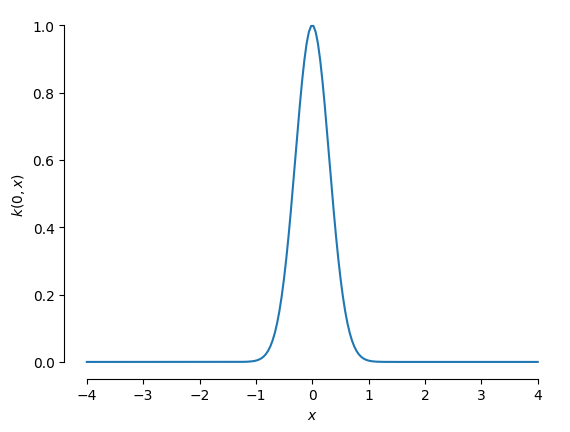

In [1159]:
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.3
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the lengthscale ?

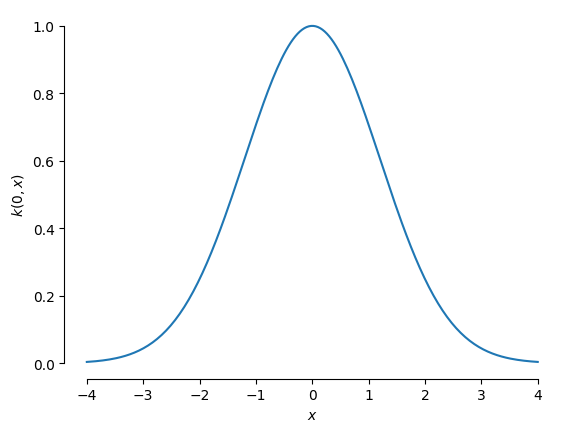

In [1160]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the variance ?

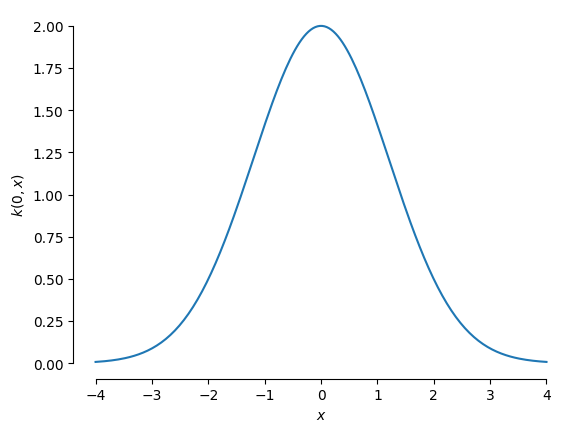

In [1161]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 2.0
plot_kernel(k)

plot maternKernel

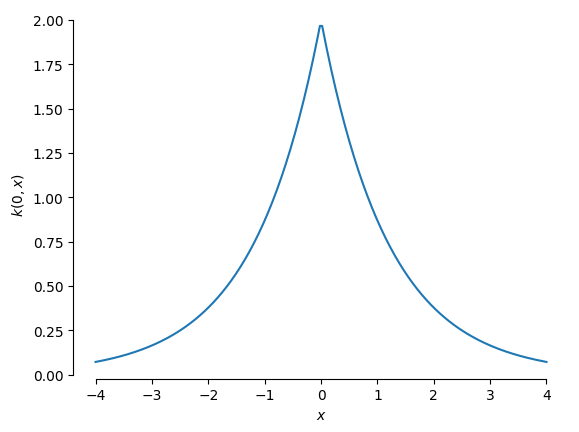

In [1162]:
k1 = ScaleKernel(MaternKernel(nu=0.5))
k1.base_kernel.lengthscale = 1.2
k1.outputscale = 2.0
plot_kernel(k1)

#### Verify that the properties of covariance functions

covariance function must be positive definite

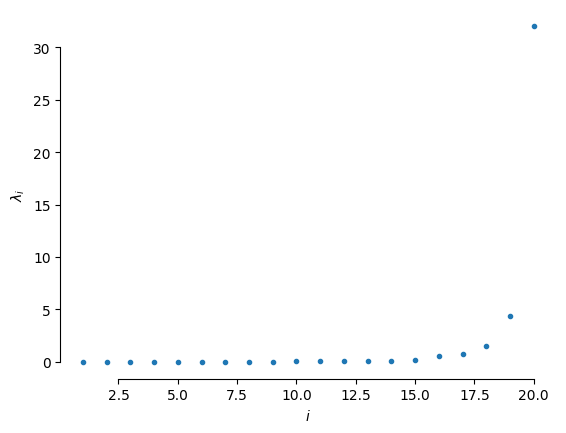

In [1163]:
k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1

n = 20

X = torch.rand(n, 1)
K = k1.forward(X, X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = torch.linalg.eigh(K)

fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_{i}$")
sns.despine(trim=True)

sum of covariance functions

In [1164]:
k1 = ScaleKernel(RBFKernel())
k1.base_kernel.lengthscale = 0.3
k1.outputscale = 1.0

k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1.5

k_new = k1 + k2

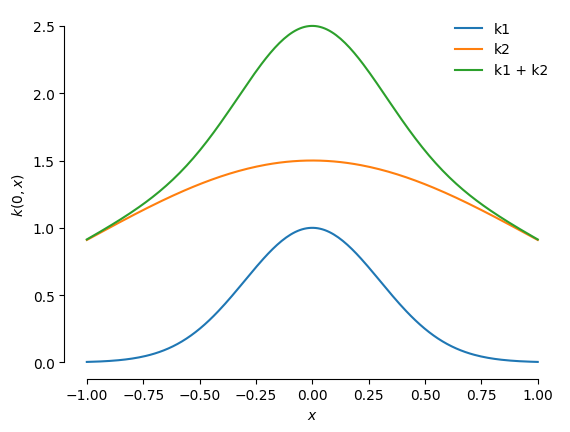

In [1165]:
fig, ax = plt.subplots()
x = torch.linspace(-1, 1, 200)[:, None]
zero = torch.zeros(1)[:, None]
ks1 = k1.forward(zero, x)
ks2 = k2.forward(zero, x)
ks_new = k_new.forward(zero, x)
ax.plot(x, ks1.detach().T, label="k1")
ax.plot(x, ks2.detach().T, label="k2")
ax.plot(x, ks_new.detach().numpy().T, label="k1 + k2")
ax.set_xlabel("$x$")
ax.set_ylabel("$k(0,x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

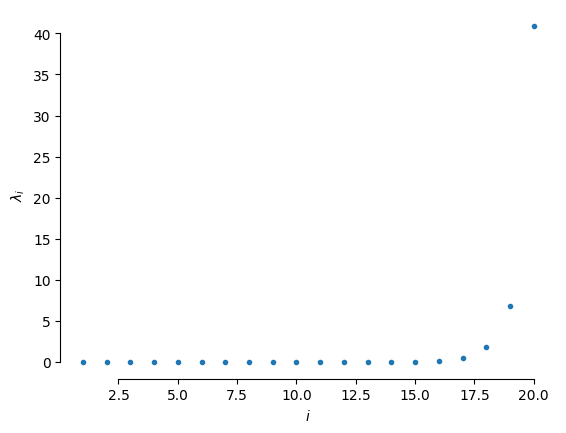

In [1166]:
K_new = k_new.forward(X, X)
eig_val, eig_vec = torch.linalg.eigh(K_new)
fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_i$")
sns.despine(trim=True)

#### Sampling from a Gaussian process

we only need to know how to sample from the multivariate normal:

$$\mathbf{f}|\mathbf{x}_{1:n}\sim\mathcal{N}(\mathbf{m}(\mathbf{x}_{1:n}),\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}))$$

1. Compute the Cholesky of $\mathbf{L}$:
$$\mathbf{K}=\mathbf{L}\mathbf{L}^T$$
2. Draw n random samples $z$ independently from a standard normal.
3. Get one sample by:
$$\mathbf{f}=\mathbf{m}+\mathbf{Lz}.$$

In [1167]:
def sample_functions(mean_func, kernel_func, num_samples=5, num_test=20, nugget=1e-5):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label="mean")
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5, label="sample" if i == 0 else None)
    plt.legend(loc="best", frameon=False)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_ylim(-3, 3)
    sns.despine(trim=True)

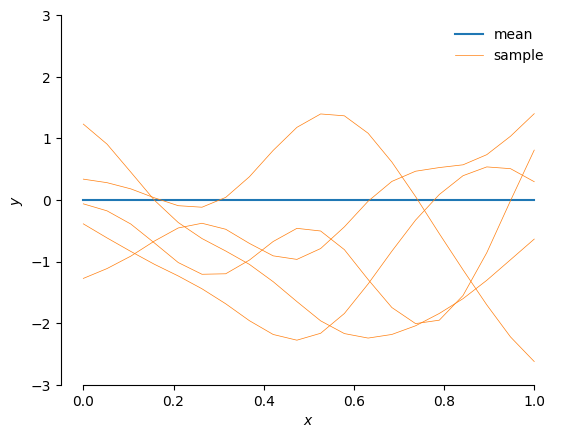

In [1168]:
from gpytorch.means import ConstantMean, LinearMean

torch.manual_seed(123)

k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0

mean_func = ConstantMean()

sample_functions(mean_func, k)

effects of the lengthscale

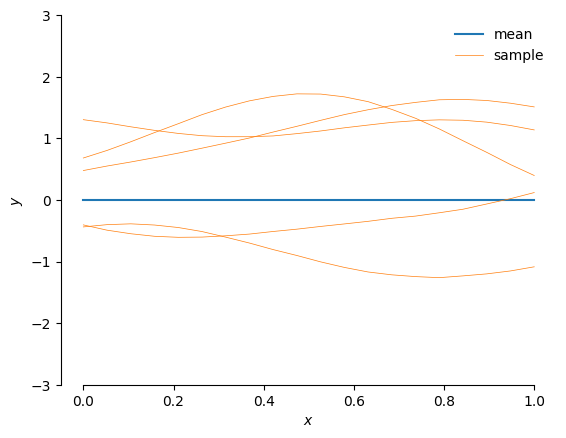

In [1169]:
mean_func = ConstantMean()
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.5
k.outputscale = 1.0
sample_functions(mean_func, k)

##### effects of mean function
Let’s do a linear mean function:
$$m(x) = ax+b$$

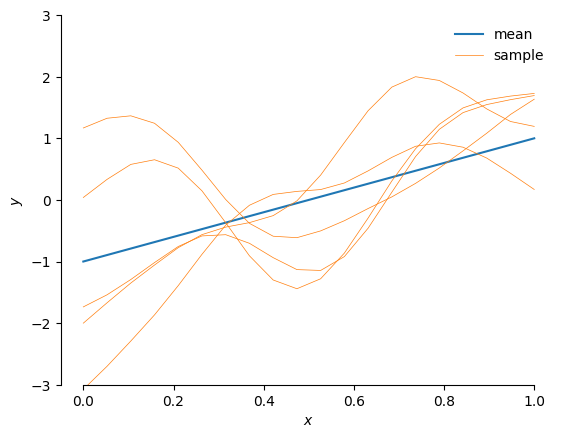

In [1170]:
a = 2.0
b = -1.0
mean_func = LinearMean(input_size=1)
mean_func.weights = torch.nn.Parameter(torch.tensor([a]))
mean_func.bias = torch.nn.Parameter(torch.tensor([b]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

Let’s use a mean function that is not in the GPytorch library. We will the mean function:
$$m(x)=a\sin(\omega x)$$
We need to inherit from the `gpytorch.means.Mean` class and implement the `forward` method:

In [1171]:
class MyMean(torch.nn.Module):
    """A custom mean function."""

    def __init__(self, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter("a", torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter("omega", torch.nn.Parameter(torch.randn(*batch_shape, 1)))

    def forward(self, x):
        return self.a * torch.sin(self.omega * x).squeeze(-1)

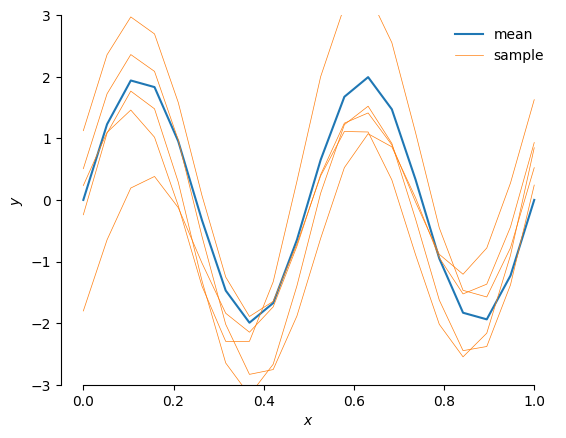

In [1172]:
a = 2.0
omega = 2.0 * np.pi * 2.0
mean_func = MyMean()
mean_func.a = torch.nn.Parameter(torch.tensor([a]))
mean_func.omega = torch.nn.Parameter(torch.tensor([omega]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

#### The smoothness of the sampled functions is controlled by the smoothness of the covariance function

Let’s look at the samples of a function that is not infinitely differentiable. We will use the Matérn covariance function:
$$k(x,x')=\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)^{\nu}K_{\nu}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)$$

Samples from the Matérn covariance function are `cell(nu)-1` times differentiable.

Let `nu = 0.5`, we get continuous but nowhere differentiable samples.

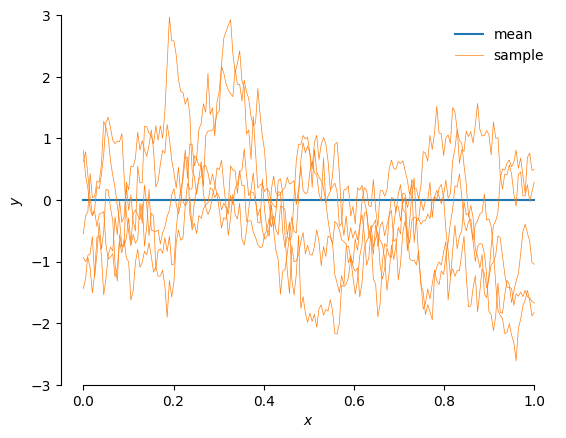

In [1173]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=0.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

Compare to `mu=1.5`

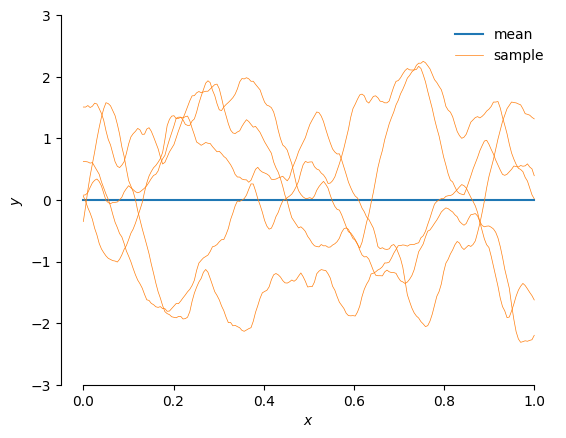

In [1174]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=1.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

#### Modeling invariances

The covariance function can also be used to model invariances. One common invariance is translation invariance:

$$f(x+\delta)=f(x),\quad\forall x\in\mathbb{R},\delta\in\mathbb{R}.$$

One can show that if the covariance function is translation invariant, then samples are also translation invariant. An example of a translation invariant covariance function is the `PeriodicKernel`:

$$k(x,x')=\exp\left\{-\frac{2}{\ell}\sin^2\left(\frac{\pi}{p}|x-x'|\right)\right\}.$$

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


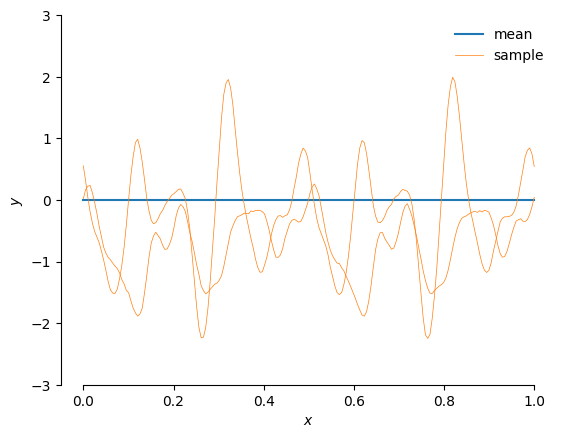

In [1175]:
from gpytorch.kernels import PeriodicKernel

mean_func = ConstantMean()
k = ScaleKernel(PeriodicKernel())
print(k.base_kernel)
k.base_kernel.period_length = 0.5
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=2, num_test=200, nugget=1e-4)

#### Stationary and non-stationary covariance functions

So far we have only used stationary covariance functions. A covariance function is stationary if it depends only on the distance between the inputs:

$$k(x,x')=k(|x-x'|).$$

This means that the samples from that covariance function look similar everywhere.

Sometimes, we want to model functions that are not behaving in a similar manner for all inputs. For example, they may have more wiggles in some parts of the input space than others. A classic non-stationary covariance function is the `LinearKernel`:

$$k(x,x')=vxx'$$

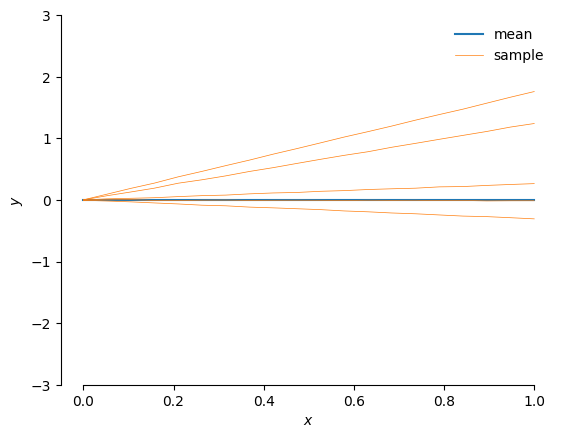

In [1176]:
from gpytorch.kernels import LinearKernel

mean_func = ConstantMean()
k = LinearKernel()
k.outputscale = 1.0
sample_functions(mean_func, k)

Another classic non-stationary covariance function is the `PolynomialKernel`:

$$k(x,x')=(x^Tx'+c)^d$$

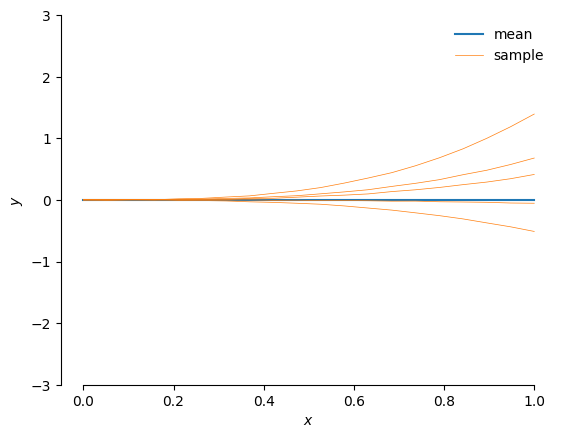

In [1177]:
from gpytorch.kernels import PolynomialKernel

mean_func = ConstantMean()
k = ScaleKernel(PolynomialKernel(power=3))
k.base_kernel.offset = 0.0
k.outputscale = 1.0
sample_functions(mean_func, k)

#### Two (or more) length scales in samples

Suppose that we have a function that is the sum of two functions: one that varies slowly and one that varies quickly. How can we model this? We need to use two covariance functions: one with a small lengthscale and one with a large lengthscale. Then we need to add the two covariance functions together. Let’s see how this works.

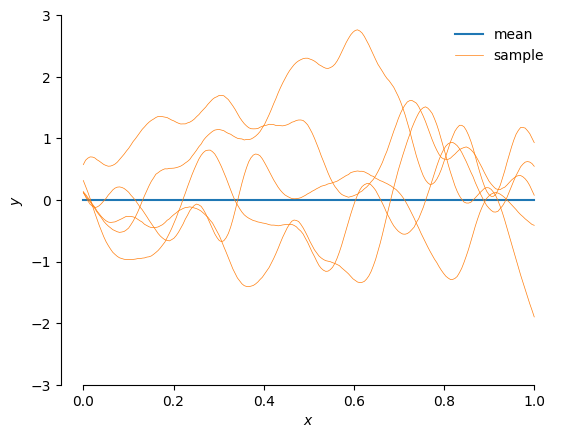

In [1178]:
mean_func = ConstantMean()
kslow = ScaleKernel(RBFKernel())
kslow.base_kernel.lengthscale = 0.3
kslow.outputscale = 1.0
kfast = ScaleKernel(RBFKernel())
kfast.base_kernel.lengthscale = 0.05
kfast.outputscale = 0.4
k = kslow + kfast
sample_functions(mean_func, k, num_samples=5, num_test=200)

### Gaussian Process Regression Without Noise

https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.1.html

#### Example: GPR in 1D with fixed hyper-parameters

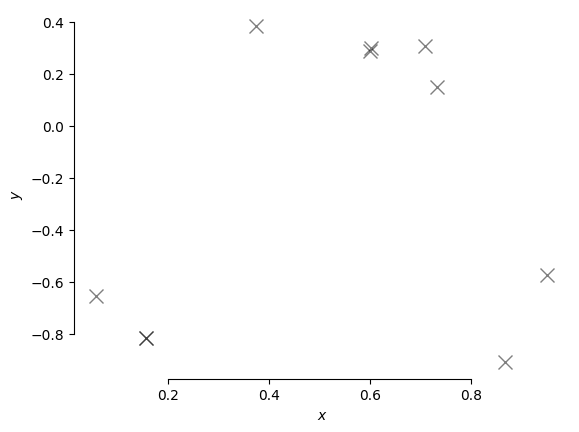

In [1179]:
np.random.seed(42)

n = 10

X = np.random.rand(n)

f_true = lambda x: -np.cos(np.pi * x) * np.sin(4 * np.pi * x)
Y = f_true(X)

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, alpha=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

sns.despine(trim=True)

A GPyTorch GP model with zero mean, squard exponential covariance function and Gaussian likelihood.

In [1180]:
from numpy import mean


class ExactGP(gpytorch.models.ExactGP):
    def __init__(
        self,
        train_x,
        train_y,
        mean_module=gpytorch.means.ConstantMean(),
        covar_module=ScaleKernel(RBFKernel()),
        likelihood=gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0)),
    ):
        super(ExactGP, self).__init__(
            train_x,
            train_y,
            likelihood,
        )
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def get_simple_model(X, Y):
    train_x = torch.from_numpy(X).float()
    train_y = torch.from_numpy(Y).float()
    model = ExactGP(train_x, train_y)
    return model

We are going to pick the parameters by hand in this example.

In [1181]:
model = get_simple_model(X, Y)
model.mean_module.constant = 0.0
model.covar_module.outputscale = 1.0
model.covar_module.base_kernel.lengthscale = 1.0
model.likelihood.noise = 0.0

That’s it. We have now specified the model completely. The posterior GP is completely defined. We can now make predictions from the model.

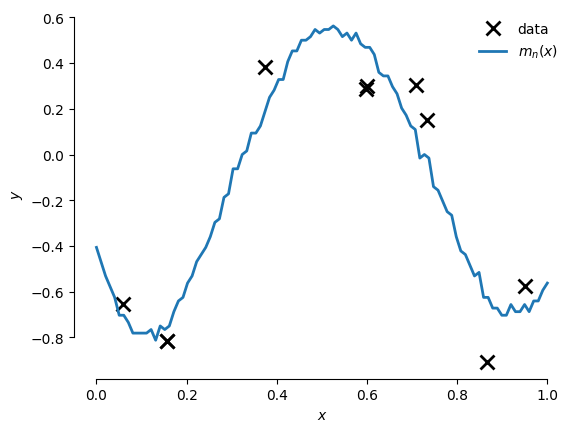

In [1182]:
model.eval()
model.likelihood.eval()

x_star = torch.linspace(0, 1, 100).unsqueeze(-1)
f_star = model(x_star)

m_star = f_star.mean

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

This GP has not enough capacity to fit the data. Try decreasing the lengthscale.

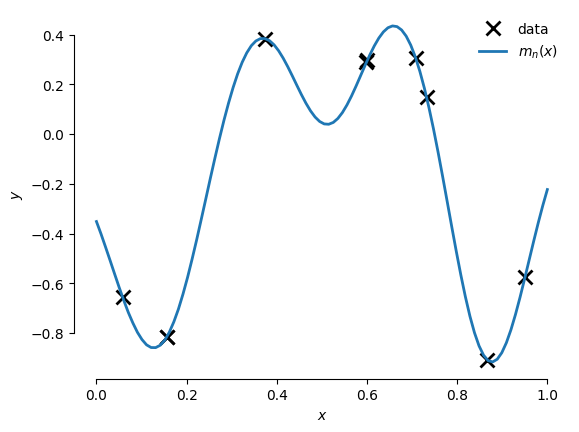

In [1183]:
model = get_simple_model(X, Y)

model.mean_module.constant = 0.0
model.covar_module.outputscale = 1.0
model.covar_module.base_kernel.lengthscale = 0.1

model.likelihood.noise = 0.0

model.eval()
model.likelihood.eval()

x_star = torch.linspace(0, 1, 100).unsqueeze(-1)
f_star = model(x_star)

m_star = f_star.mean

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

The variance on the same test points

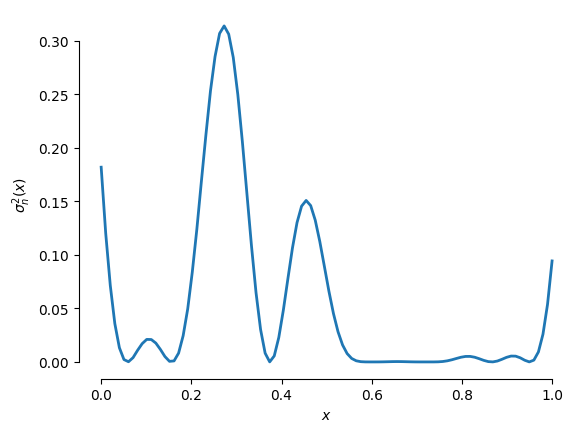

In [1184]:
fig, ax = plt.subplots()
v_star = f_star.variance
ax.plot(x_star, v_star.detach(), lw=2, label="$\sigma_n^2(x)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$\sigma_n^2(x)$")
sns.despine(trim=True)

Having the posterior mean and variance, we can derive 95% predictive intervals.

$$m_n(\mathbf{x}^*))-2\sigma_n(\mathbf{x}^*)\leq f(\mathbf{x}^*)\leq m_n(\mathbf{x}^*))+2\sigma_n(\mathbf{x}^*).$$

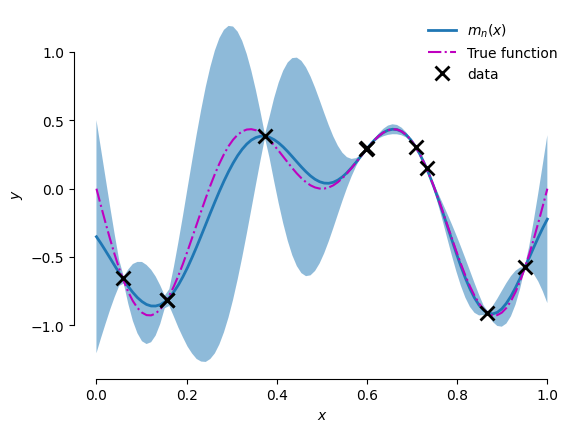

In [1185]:
fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
f_lower = m_star - 2.0 * torch.sqrt(v_star)
f_upper = m_star + 2.0 * torch.sqrt(v_star)
ax.fill_between(x_star.detach().flatten(), f_lower.detach().flatten(), f_upper.detach().flatten(), alpha=0.5)
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
ax.plot(x_star, f_true(x_star), "m-.", label="True function")
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

We have much more information encoded in the posterior GP. It is a probability measure over the space of functions. How do we sample functions? Well, you can’t sample functions. They are infinite objects. But you can sample the function values on many test points. The joint probability density of the function values at any collection of set points is a multivariate Gaussian.

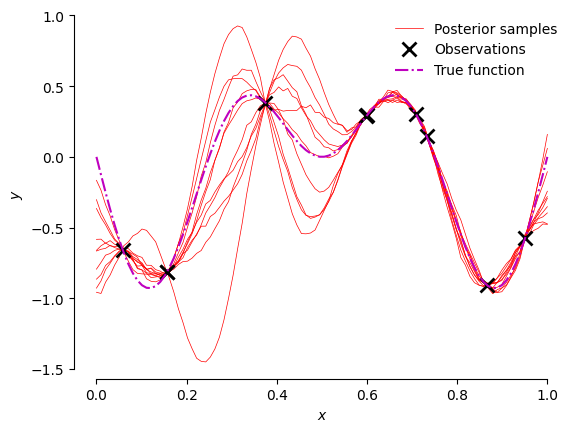

In [1186]:
f_post_samples = f_star.sample(sample_shape=torch.Size([10]))

fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples.detach().T, "r", lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="Observations")
ax.plot(x_star, f_true(x_star), "m-.", label="True function")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

Okay, the length scale we have assumed does not match the length scale of the actual function perfectly. But that’s how it is. In real problems, you won’t know this function anyway.

As always, it is a good idea to arrange your code in functions for reusability:

In [1187]:
def plot_1d_regression(x_star, model, ax=None, f_true=None, num_samples=10):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance

    f_lower = m_star - 2.0 * torch.sqrt(v_star)
    f_upper = m_star + 2.0 * torch.sqrt(v_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")

    ax.fill_between(x_star.flatten().detach(), f_lower.flatten().detach(), f_upper.flatten().detach(), alpha=0.5, label="$f(\mathbf{x}^*)$ 95% pred.")

    if f_true is not None:
        ax.plot(x_star, f_true(x_star), "m-.", label="True function")

    ax.plot(model.train_inputs[0].flatten().detach(), model.train_targets.detach(), "kx", markersize=10, markeredgewidth=2, label="Observations")

    if num_samples > 0:
        f_post_samples = f_star.sample(sample_shape=torch.Size([10]))
        ax.plot(x_star, f_post_samples.T.detach(), "r", lw=0.5)
        ax.plot([], [], "r", lw=0.5, label="Posterior samples")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

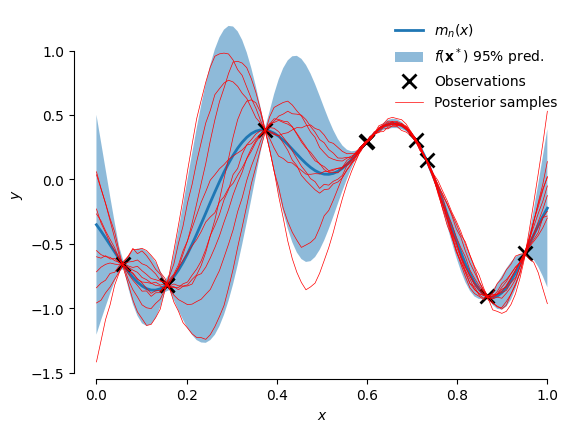

In [1188]:
plot_1d_regression(x_star, model)

#### Diagnostics: How do you know if the fit is good?

To objective test the resulting model, we need a validation dataset.

##### Point-predictions

###### MSE

$$\mathrm{MSE}:=\frac{1}{n^{v}}\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-m_{n}\left(\mathbf{x}_{i}^{v}\right)\right]^{2}.$$

###### R-Squared

A somewhat intuitive measure is coefficient of determination, also known as R-squared.

$$R^{2}=1-\frac{\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-m_{n}(\mathbf{x}_{i}^{v})\right]^{2}}{\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-\bar{y}^{v}\right]^{2}},$$


In [1189]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v)


f_v = model(torch.from_numpy(X_v).float())
m_v = f_v.mean.detach().numpy()
v_v = f_v.variance.detach().numpy()
mse = np.mean((Y_v - m_v) ** 2)
print(f"MSE = {mse:1.2f}")

R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print(f"R2 = {R2:1.2f}")

MSE = 0.41
R2 = -192.03


Finally, on point-predictions, we can simply plot the predictions vs the observations:

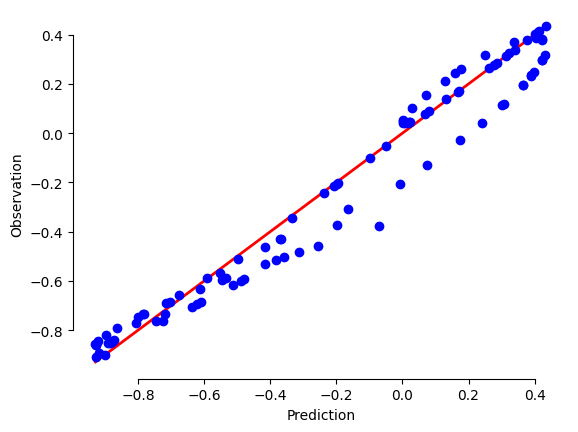

In [1190]:
fig, ax = plt.subplots()
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, "r", lw=2)
ax.plot(Y_v, m_v, "bo")
ax.set_xlabel("Prediction")
ax.set_ylabel("Observation")
sns.despine(trim=True)

### Gaussian Process Regression with Noise

We perform Gaussian process regression with measurement noise. The noise is assumed to be Gaussian with a known variance. The hyper-parameters of the Gaussian process are assumed to be known

#### GPR in 1D with fixed hyper-parameters and noise

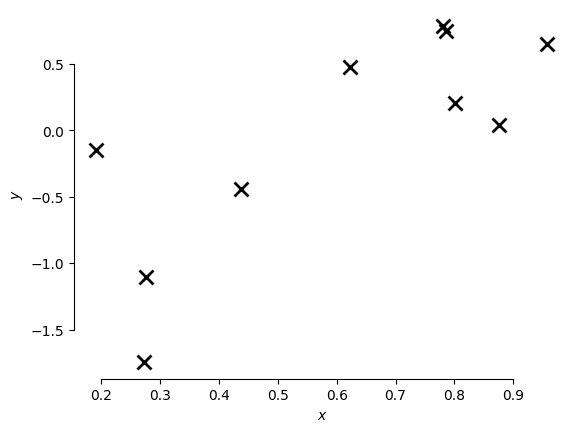

In [1191]:
np.random.seed(1234)

n = 10
X = np.random.rand(n)
sigma = 0.4
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4.0 * np.pi * x)
Y = f_true(X) + sigma * np.random.randn(X.shape[0])

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
sns.despine(trim=True)

The only difference from previous model is that add noise to the likelihood

In [1192]:
model = get_simple_model(X, Y)

model.mean_module.constant = torch.tensor(0.0)
model.covar_module.outputscale = torch.tensor(1.0)
model.covar_module.base_kernel.lengthscale = torch.tensor(0.1)
model.likelihood.noise = torch.tensor(sigma**2)

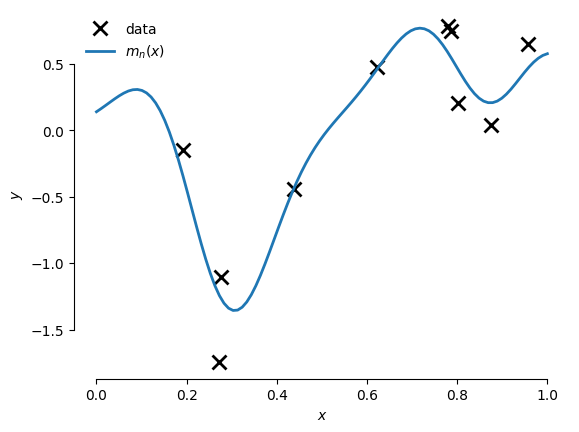

In [1193]:
model.eval()
model.likelihood.eval()

x_star = torch.linspace(0, 1, 100)[:, None]
f_star = model(x_star)
# Now we need to pass through the likelihood - this is different from before
y_star = likelihood(f_star)

m_star = y_star.mean
fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

Extracting the variance is a bit more involved. This is because `v_star` returned by gpm.predict is not exactly $\sigma_n^2(x)$. It is actually $\sigma_n^2(x) + \sigma^2$ and not just $\sigma_n^2(x)$. Here, see it:

In [1194]:
v_star = f_star.variance
yv_star = y_star.variance

Let’s now take some samples from the posterior

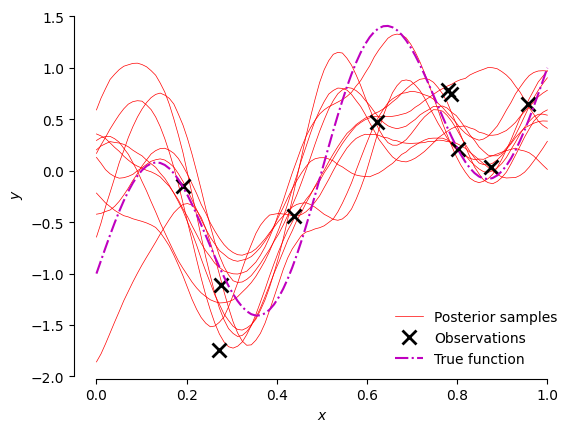

In [1195]:
f_post_samples = f_star.sample(sample_shape=torch.Size([10]))

fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples.detach().T, "r", lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="Observations")
ax.plot(x_star, f_true(x_star), "m-.", label="True function")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

As before, let’s organize the code into a function:

In [1196]:
def plot_1d_regression_noise(x_star, model, ax=None, f_true=None, num_samples=10):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = m_star - 2.0 * torch.sqrt(v_star)
    f_upper = m_star + 2.0 * torch.sqrt(v_star)

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(), model.train_targets.detach(), "kx", markersize=10, markeredgewidth=2, label="Observations")

    ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$", color=sns.color_palette()[0])

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label="$f(\mathbf{x}^*)$ 95% pred.",
        color=sns.color_palette()[0],
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label="$y^*$ 95% pred.",
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None,
    )

    if f_true is not None:
        ax.plot(x_star, f_true(x_star), "m-.", label="True function")

    if num_samples > 0:
        f_post_samples = f_star.sample(sample_shape=torch.Size([10]))
        ax.plot(x_star, f_post_samples.T.detach(), color="red", lw=0.5)
        # This is just to add the legend entry
        ax.plot([], [], color="red", lw=0.5, label="Posterior samples")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

    return m_star, v_star

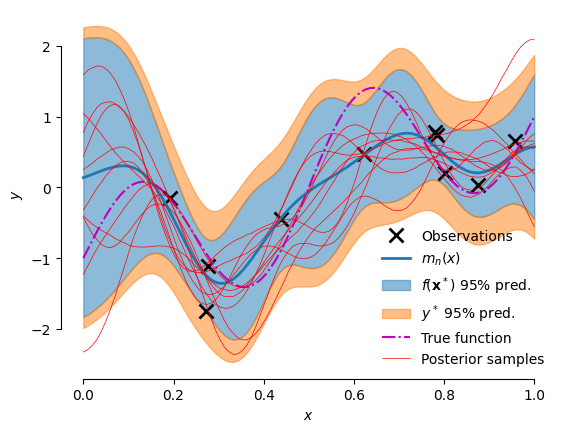

In [1197]:
_ = plot_1d_regression_noise(x_star, model, f_true=f_true)

#### Statistical diagnostics

Statistical diagnostics compare the predictive distribution to the distribution of the validation dataset. The way to start are the standardized errors defined by:

$$e_i=\frac{y_i^v-m_n\left(\mathbf{x}_i^v\right)}{\sigma_n\left(\mathbf{x}_i^v\right)}.$$

If our model is correct, the standardized errors must be distributed as a standard normal N(0,1). There are various plots that you can do to test that. First, the histogram of the standardized errors:

In [1198]:
n_v = 100
X_v = np.random.rand(n_v)
Y_v = f_true(X_v) + sigma * np.random.randn(n_v)
X_v = torch.from_numpy(X_v).float()
Y_v = torch.from_numpy(Y_v).float()

f_v = model(X_v)
y_v = model.likelihood(f_v)
m_v = y_v.mean
v_v = y_v.variance

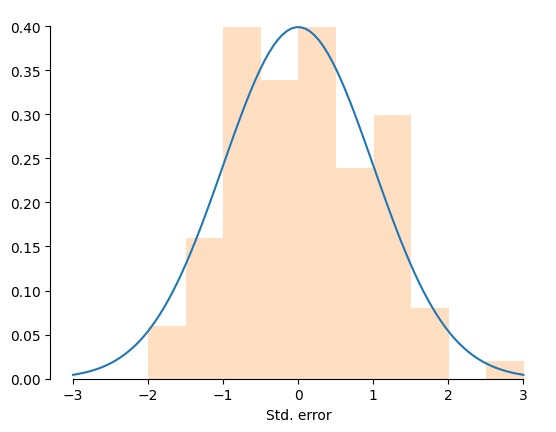

In [1199]:
s_v = torch.sqrt(v_v)
e = (Y_v - m_v) / s_v
fig, ax = plt.subplots()
zs = np.linspace(-3.0, 3.0, 100)
ax.plot(zs, st.norm.pdf(zs))
ax.hist(e.detach(), density=True, alpha=0.25)
ax.set_xlabel("Std. error")
sns.despine(trim=True)

Close, but not perfect. Another common plot is this:

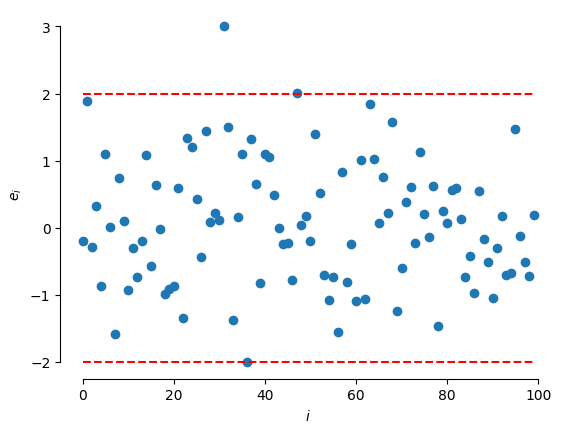

In [1200]:
fig, ax = plt.subplots()
ax.plot(e.detach(), "o")
ax.plot(np.arange(e.shape[0]), 2.0 * np.ones(e.shape[0]), "r--")
ax.plot(np.arange(e.shape[0]), -2.0 * np.ones(e.shape[0]), "r--")
ax.set_xlabel("$i$")
ax.set_ylabel("$e_i$")
sns.despine(trim=True)

Yet another plot yielding the same information is the q-q plot comparing the empirical quantiles of the standardized errors to what they are supposed to be, i.e., to the quantiles of N(0,1)

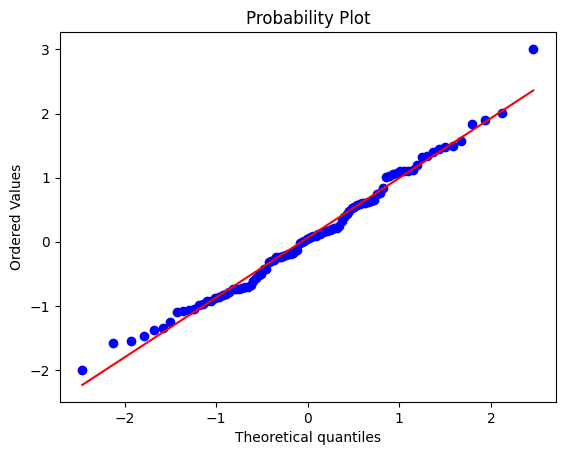

In [1201]:
fig, ax = plt.subplots(dpi=100)
st.probplot(e.detach().flatten(), dist=st.norm, plot=ax)
plt.show()

### Tuning the Hyperparameters

https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.3.html

 GP model has the following parameters:
 - `model.mean.constant`: the constant of the mean function.
 - `model.covar_module.outputscale`: the output scale of the kernel (variance or signal strength).
 - `model.covar_module.base_kernel`.lengthscale: the length scale of the kernel.
 - `model.likelihood.noise`: the standard deviation of the noise.

 The mean constant can be any real number. The output scale, the length scale, and the noise standard deviation must be positive. Typically, one explicitly enforces the constraints by working with a transformed version of the parameters. GPyTorch automatically does this for us. If you want to learn more about this. GPyTorch calls the transformed parameters `raw_<NAME>`.

In [1202]:
model = get_simple_model(X, Y)


for name, param in model.named_parameters():
    print(f"Parameter name: {name:42} value = {param.item():1.2f}")

Parameter name: likelihood.noise_covar.raw_noise           value = -1.75
Parameter name: mean_module.raw_constant                   value = 0.00
Parameter name: covar_module.raw_outputscale               value = 0.54
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -2.25


We can maximize the marginal log likelihood to train a GP.

In [1203]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss

    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f"Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}")
    model.eval()

the default values of parameters:

In [1204]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name:42} value = {param.item():1.2f}")

Parameter name: likelihood.noise_covar.raw_noise           value = -1.75
Parameter name: mean_module.raw_constant                   value = 0.00
Parameter name: covar_module.raw_outputscale               value = 0.54
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -2.25


train models

In [1205]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

train(model, train_x, train_y)

Iter   1/10 - Loss: 1.007
Iter   2/10 - Loss: 0.939
Iter   3/10 - Loss: 0.939
Iter   4/10 - Loss: 0.939
Iter   5/10 - Loss: 0.939
Iter   6/10 - Loss: 0.939
Iter   7/10 - Loss: 0.939
Iter   8/10 - Loss: 0.939
Iter   9/10 - Loss: 0.939
Iter  10/10 - Loss: 0.939


the parameters value after training

In [1206]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name:42} value = {param.item():1.2f}")

Parameter name: likelihood.noise_covar.raw_noise           value = -1.75
Parameter name: mean_module.raw_constant                   value = -0.04
Parameter name: covar_module.raw_outputscale               value = -0.65
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -3.58


Let’s plot the predictions:

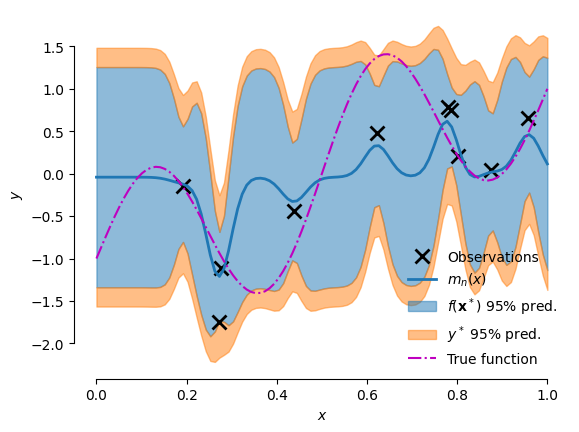

In [1207]:
x_star = torch.linspace(0, 1, 100)
_ = plot_1d_regression_noise(x_star, model, f_true=f_true, num_samples=0)

Admittedly, this could look better. (We can tell this only because we know the truth). The assigned length scale is too small. Also, the likelihood variance seems smaller than it is.  You have two choices:
- **You encode some prior knowledge and repeat.**
- **You add some more data and repeat.**

Let’s start with prior knowledge. Let’s say that we know that the noise variance.

In [1208]:
model.likelihood.noise_covar.noise = 0.1

# Verify that the change went through
print(f"noise: {model.likelihood.noise.item():.3f}")

# To make sure that the noise is not optimized, we need to do:
model.likelihood.raw_noise.requires_grad_(False)

noise: 0.100


Parameter containing:
tensor([-2.2522])

This makes the optimizer ignore the noise parameter. Let’s retrain:

In [1209]:
train(model, train_x, train_y)

Iter   1/10 - Loss: 0.939
Iter   2/10 - Loss: 0.939
Iter   3/10 - Loss: 0.939
Iter   4/10 - Loss: 0.939
Iter   5/10 - Loss: 0.939
Iter   6/10 - Loss: 0.939
Iter   7/10 - Loss: 0.939
Iter   8/10 - Loss: 0.939
Iter   9/10 - Loss: 0.939
Iter  10/10 - Loss: 0.939


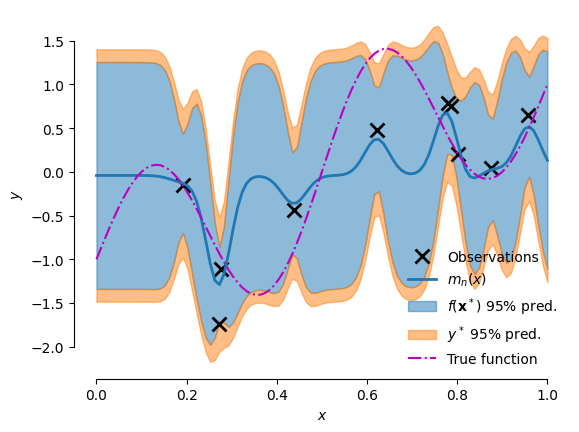

In [1210]:
_ = plot_1d_regression_noise(x_star, model, f_true=f_true, num_samples=0)

This looks better. But, the automatically selected length scale seems smaller than the true one. Let’s assign a prior probability density on the length scale so that it is forced to be greater. Since we are dealing with a positive parameter and we don’t know much about it, let’s assign an exponential prior with a rate of 2 (which will yield an expectation of 0.5) : 
$$\ell\sim\mathrm{Log-N}(0.2,1)$$

In [1211]:
model.covar_module.register_prior(
    "lengthscale_prior",
    gpytorch.priors.LogNormalPrior(0.5, 1),
    lambda module: module.base_kernel.lengthscale,
)

train(model, train_x, train_y)

Iter   1/10 - Loss: 1.510
Iter   2/10 - Loss: 1.226
Iter   3/10 - Loss: 1.226
Iter   4/10 - Loss: 1.226
Iter   5/10 - Loss: 1.226
Iter   6/10 - Loss: 1.226
Iter   7/10 - Loss: 1.226
Iter   8/10 - Loss: 1.226
Iter   9/10 - Loss: 1.226
Iter  10/10 - Loss: 1.226


In [1212]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name:42} value = {param.item():1.2f}")

print(f"mean constant: {model.mean_module.constant.item():.3f}")
print(f"output scale: {model.covar_module.outputscale.item():.3f}")
print(f"length scale: {model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"noise: {model.likelihood.noise.item():.3f}")

Parameter name: likelihood.noise_covar.raw_noise           value = -2.25
Parameter name: mean_module.raw_constant                   value = 0.08
Parameter name: covar_module.raw_outputscale               value = -0.22
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -2.14
mean constant: 0.081
output scale: 0.589
length scale: 0.111
noise: 0.100


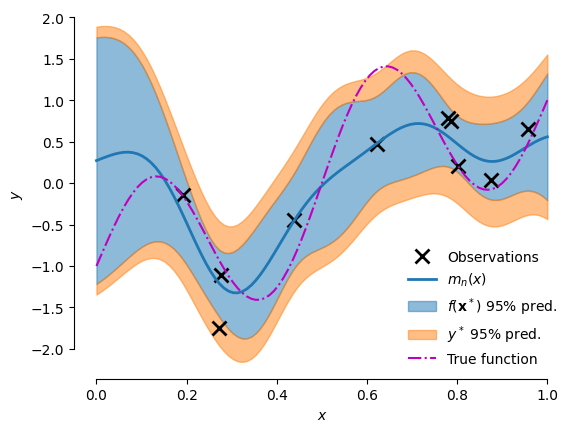

In [1213]:
_ = plot_1d_regression_noise(x_star, model, f_true=f_true, num_samples=0)

That’s better, but not perfect. But remember: You don’t know what the truth is. There is only so much you can get without additional data.

### Multivariate Gaussian Process Regression

https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.4.html

We perform multivariate Gaussian process regression with automatic relevance determination. When we say “multivariate” here, we refer to many function inputs, not outputs. This means that the input of the function we are interested in learning is a vector $x$ in $\mathcal{R}^D$. Nothing changes compared to one-input GPR. 

**However, in higher dimensional settings, one must pay attention to selecting the covariance function.**

Let’s demonstrate this using an example. Here is an analytical function known as the Branin-Hoo function:

$$f(\mathbf{x})=f(x_1,x_2)=\frac1{51.95}{\left[\left(15x_2-\frac{5.1(15x_1)^2}{4\pi^2}+\frac{75x_1}\pi-6\right)^2+\left(10-\frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]}$$

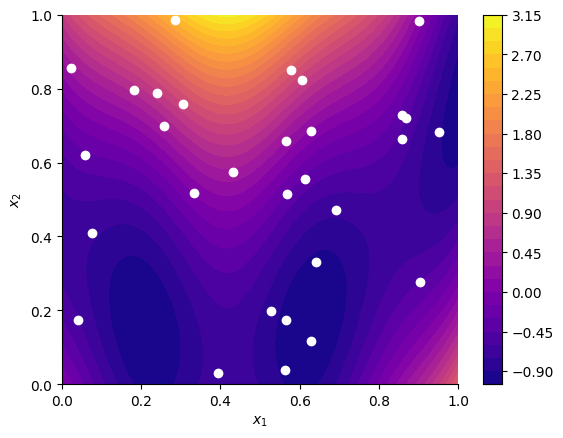

In [1214]:
# Define the function
def f_branin(x):
    """Input must be 2D array of size N x 2."""
    return (
        1.0
        / 51.95
        * (
            (15.0 * x[:, 1] - 5.1 * ((15.0 * x[:, 0]) ** 2 / (4.0 * np.pi**2)) + 75.0 * x[:, 0] / np.pi - 6.0) ** 2
            + ((10.0 - 10.0 / (8.0 * np.pi)) * np.cos(15.0 * x[:, 0]))
            - 44.81
        )
    )


N = 30
Xdata = np.random.rand(N, 2)
sigma = 0.01
Ydata = f_branin(Xdata) + sigma * np.random.randn(N)

fig = plt.figure()
ax = plt.subplot(111)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
Xs = np.vstack([X1.flatten(), X2.flatten()]).T
Y = f_branin(Xs).reshape((100, 100))

c = ax.contourf(X1, X2, Y, 30, cmap="plasma")
plt.colorbar(c)
ax.plot(Xdata[:, 0], Xdata[:, 1], "o", color="white")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
sns.despine(trim=True)

We will be using a the squared exponential covariance function for a regression along with a constant mean. So our prior GP is:

$$f(\cdot)\sim\mathrm{GP}(0,k(\cdot,\cdot)),$$

with

$$k(\mathbf{x},\mathbf{x}')=s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1^2}-\frac{(x_2-x_2')^2}{2\ell_2^2}\right).$$

The first, situation we are going to examin is when the lengthscales are the same:

$$\ell_1=\ell_2.$$

In [1215]:
train_x = torch.from_numpy(Xdata).float()
train_y = torch.from_numpy(Ydata).float()
# model = ExactGP(train_x, train_y)
model = get_simple_model(Xdata, Ydata)

train(model, train_x, train_y, n_iter=10)

Iter   1/10 - Loss: 0.931
Iter   2/10 - Loss: 0.482
Iter   3/10 - Loss: 0.482
Iter   4/10 - Loss: 0.482
Iter   5/10 - Loss: 0.482
Iter   6/10 - Loss: 0.482
Iter   7/10 - Loss: 0.482
Iter   8/10 - Loss: 0.482
Iter   9/10 - Loss: 0.482
Iter  10/10 - Loss: 0.482


Check the lengthscales:

In [1216]:
print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
print(f"length scale:\t{model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

mean constant:	0.053
output scale:	1.401
length scale:	0.447
noise:		0.100


Make predictions:

In [1217]:
fpred_flat = model(torch.from_numpy(Xs).float())
Ypred_flat = fpred_flat.mean.detach().numpy()
Yvar_flat = model.likelihood(fpred_flat).variance.detach().numpy()

Text(0, 0.5, '$x_2$')

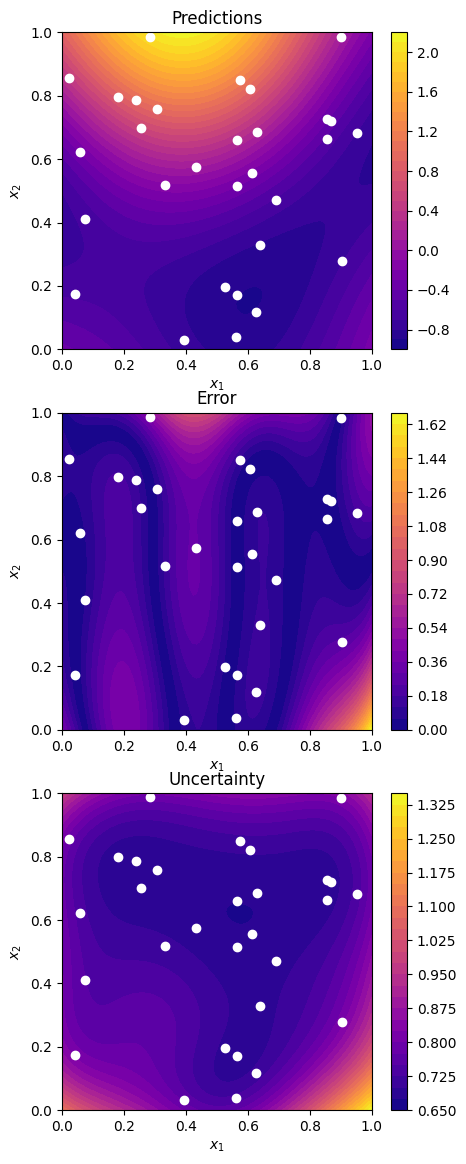

In [1218]:
fig, ax = plt.subplots(3, 1, figsize=(5, 14))

Ypred = Ypred_flat.reshape((100, 100))
im = ax[0].contourf(X1, X2, Ypred, 30, cmap="plasma")
c = plt.colorbar(im, ax=ax[0])
ax[0].plot(Xdata[:, 0], Xdata[:, 1], "o", color="white")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title("Predictions")

# Error
E = np.abs(Y - Ypred)
im = ax[1].contourf(X1, X2, E, 30, cmap="plasma")
ax[1].plot(Xdata[:, 0], Xdata[:, 1], "o", color="white")
c = plt.colorbar(im, ax=ax[1])
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
ax[1].set_title("Error")

# Uncertainty
im = ax[2].contourf(X1, X2, 2.0 * np.sqrt(Yvar_flat.reshape(X1.shape)), 30, cmap="plasma")
ax[2].set_title("Uncertainty")
c = plt.colorbar(im, ax=ax[2])
ax[2].plot(Xdata[:, 0], Xdata[:, 1], "o", color="white")
ax[2].set_xlabel("$x_1$")
ax[2].set_ylabel("$x_2$")

Let’s get some test data and make some predictions.

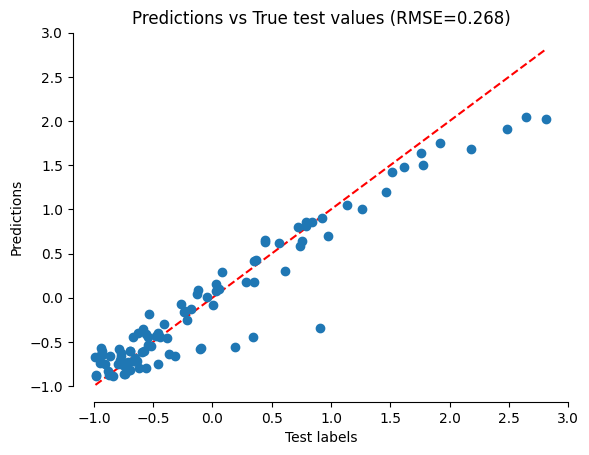

In [1219]:
from sklearn.metrics import mean_squared_error

Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt(mean_squared_error(Ytest, Ytest_m))

fig, ax = plt.subplots()
ys = np.linspace(np.min(Ytest), np.max(Ytest), 100)
ax.plot(ys, ys, "r--", label="$x=y$")
ax.plot(Ytest, Ytest_m, "o")
ax.set_title(f"Predictions vs True test values (RMSE={error_m:.3f})")
ax.set_xlabel("Test labels")
ax.set_ylabel("Predictions")
sns.despine(trim=True)

 Let’s repeat the same analysis but allowing for a different lengthscale per input. 

In [1220]:
model = ExactGP(train_x, train_y, covar_module=ScaleKernel(RBFKernel(ard_num_dims=2)))
train(model, train_x, train_y)

Iter   1/10 - Loss: 0.706
Iter   2/10 - Loss: 0.440
Iter   3/10 - Loss: 0.440
Iter   4/10 - Loss: 0.440
Iter   5/10 - Loss: 0.440
Iter   6/10 - Loss: 0.440
Iter   7/10 - Loss: 0.440
Iter   8/10 - Loss: 0.440
Iter   9/10 - Loss: 0.440
Iter  10/10 - Loss: 0.440


In [1221]:
print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
for i in range(2):
    print(f"length scale {i}:\t{model.covar_module.base_kernel.lengthscale[0, i].item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

mean constant:	0.249
output scale:	1.530
length scale 0:	0.400
length scale 1:	0.533
noise:		0.100


The length scale assigned to $x1$ is slightly smaller than that given to $x2$. This means the first input is more important than the second one. This is the automatic relevance determination (ARD) in action.

Now, let’s make some predictions with the ARD version of the GP regression model.

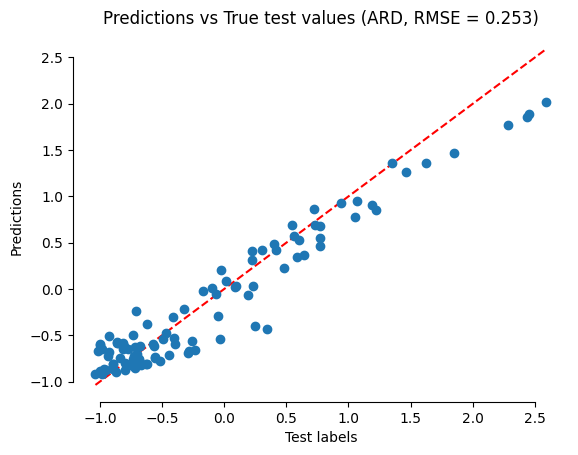

In [1222]:
Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt(mean_squared_error(Ytest, Ytest_m))

fig, ax = plt.subplots()
ys = np.linspace(np.min(Ytest), np.max(Ytest), 100)
ax.plot(ys, ys, "r--", label="$x=y$")
ax.plot(Ytest, Ytest_m, "o")
ax.set_title(f"Predictions vs True test values (ARD, RMSE = {error_m:.3f})")
ax.set_xlabel("Test labels")
ax.set_ylabel("Predictions")
sns.despine(trim=True)

### Bayesian Global Optimization

We are going to address the problem:

$$\mathbf{x}^*=\arg\max_\mathbf{x}f(\mathbf{x}).$$

under the assumption that:

- we can evaluate $f(x)$ at any $x$;
- evaluating $f(x)$ takes a lot of time/money;
- we cannot evaluate the gradient $\nabla f(\mathbf{x})$;
- the dimensionality of $x$ is not very high.

Bayesian optimization does sequential information acquisition for optimization. It is just an algorithm that tells us where to evaluate a function next if we would like to find its maximum/minimum. The problem can be formulated in a rigorous mathematical way using the theory and tools of dynamic programming. However, the full-fledged mathematical problem of designing optimal evaluation policies tends to be more complicated than the original problem of maximizing a function. So, we usually resort to heuristics. 

#### Maximum Mean - A Bad Information Acquisition Function

An naive information acquisition function is to select the arm with the highest mean. This is a bad idea. You should never do this. We will show why.

In [1223]:
def f(x):
    """A function to optimize."""
    return -4 * (1.0 - np.sin(6 * x + 8 * np.exp(6 * x - 7.0)))


x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine(trim=True)

In [1224]:
np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, "kx", markersize=10, markeredgewidth=2)
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine(trim=True)

In [1225]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-4
model.eval()

plot_1d_regression(torch.from_numpy(x).float(), model, f_true=f)

GPyTorch provide a useful function: `set_train_data`.

In [1226]:
help(model.set_train_data)

Help on method set_train_data in module gpytorch.models.exact_gp:

set_train_data(inputs=None, targets=None, strict=True) method of __main__.ExactGP instance
    Set training data (does not re-fit model hyper-parameters).

    :param torch.Tensor inputs: The new training inputs.
    :param torch.Tensor targets: The new training targets.
    :param bool strict: (default True) If `True`, the new inputs and
        targets must have the same shape, dtype, and device
        as the current inputs and targets. Otherwise, any shape/dtype/device are allowed.



Let’s start with the naive assumption that we should evaluate the function at the point that maximizes the Gaussian process posterior mean. In other words, the information acquisition function is the posterior mean of the Gaussian process. Let’s see what happens.

In [1227]:
def maximize_naive(f, model, X_design, max_it=6):
    """
    Optimize f using a limited number of evaluations.

    Arguments
    f        --  The function to optimize.
    model    --  A Gaussian process model to use for representing our state of knowledge.
    X_design --  The set of candidate points for identifying the maximum.
    max_it   --  The maximum number of iterations.
    """
    for count in range(max_it):
        model.train()
        model.eval()
        m = model(X_design).mean.detach()
        i = np.argmax(m)

        new_x = X_design[i : (i + 1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)
        model.train()
        model.eval()

        fig, ax = plt.subplots()
        plot_1d_regression(X_design, model, ax=ax, f_true=f, num_samples=0)
        ax.plot(x[i], f(x[i]), "go", label="Next observation")
        ax.set_title("BGO iteration #{0:d}".format(count + 1))
        plt.legend(loc="best", frameon=False)
        sns.despine(trim=True)

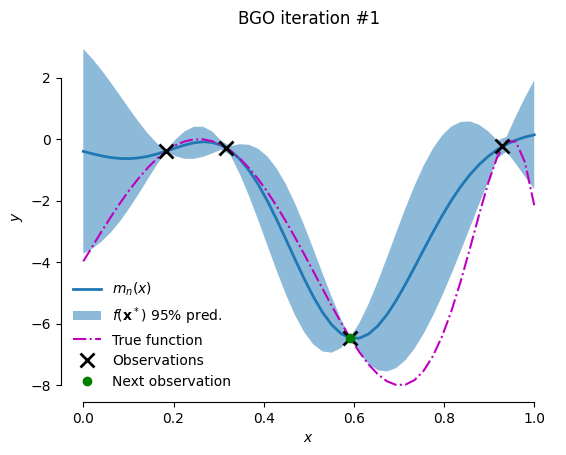

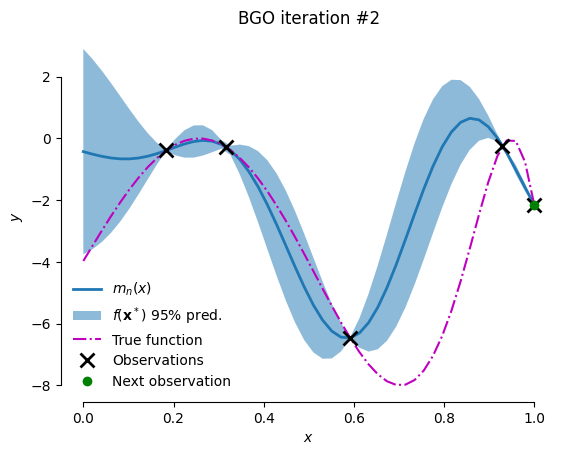

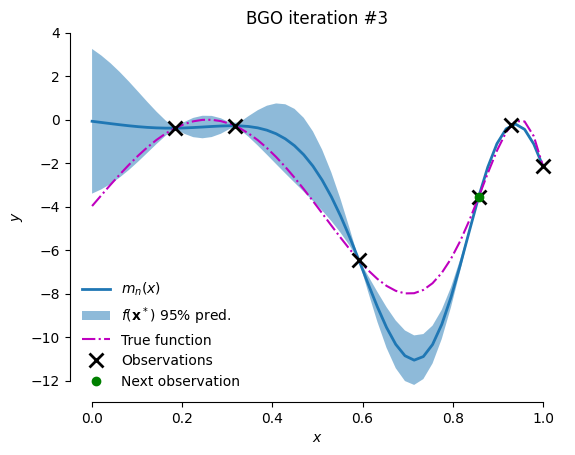

In [1228]:
X_design = torch.from_numpy(x).float()
model.train()
maximize_naive(f, model, X_design, max_it=3)

Observe that the algorithm misses the actual maximum. It gets trapped. This is because using the posterior mean as an acquisition function focuses too much on **exploiting** the currently available information but fails to **explore** regions of the input space that we have yet to visit.

#### Maximum Upper Interval

The maximum upper interval is defined to be:

$$a_n(\mathbf{x})=\mu_n(\mathbf{x})+\psi\sigma_n(\mathbf{x})$$

The parameter $\psi$ controls your emphasis on exploitation and exploration. 

In [1229]:
def plot_iaf(x_star, gpr, alpha, alpha_params={}, ax=None, f_true=None):
    """Plot the information acquisition function.

    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.

    The evaluation of the information acquisition function
    is as follows:

        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title(", ".join(f"{n}={k:.2f}" for n, k in alpha_params.items()))

    m, v = plot_1d_regression_noise(x_star, gpr, ax=ax, f_true=f_true, num_samples=0)

    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]

    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel("Maximum Upper Interval", color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), torch.linspace(0, af_max.item(), 100), color=sns.color_palette()[1], linewidth=1)


def maximize(f, model, X_design, alpha, alpha_params={}, max_it=10, optimize=False, plot=False, **kwargs):
    """Optimize a function using a limited number of evaluations.

    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.

    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)

        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(m, sigma, y_train.max(), **alpha_params)

        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])

        new_x = X_design[i : (i + 1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)

        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()

        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(X_design, model, alpha, alpha_params=alpha_params, f_true=f, ax=ax)
            ax.set_title(f"N={count}, " + ax.get_title())
    return af_all

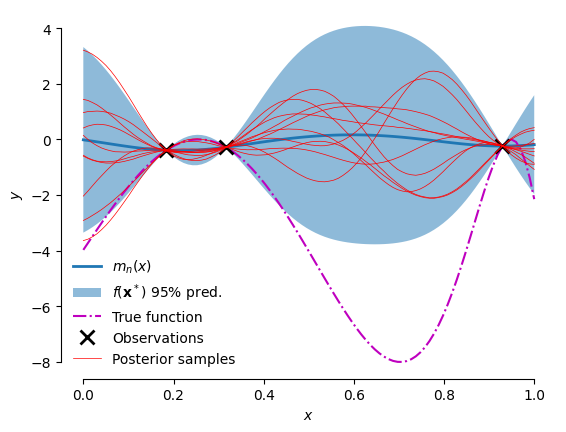

In [1230]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(x, model, f_true=f)

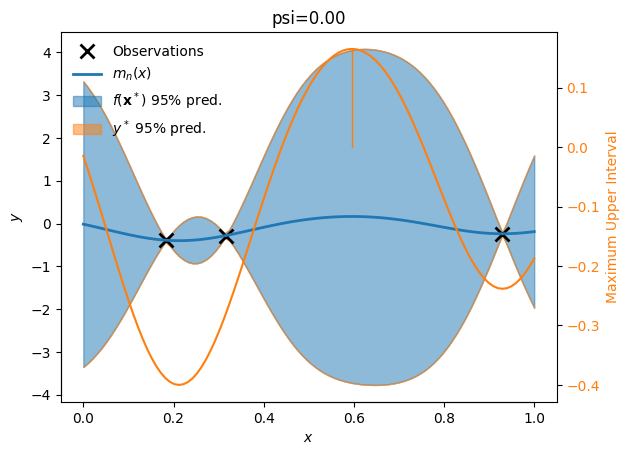

In [1231]:
def mui(m, sigma, ymax, psi=1.96):
    """The maximum upper interval acquisition function."""
    return m + psi * sigma


plot_iaf(x, model, mui, alpha_params=dict(psi=0.0))

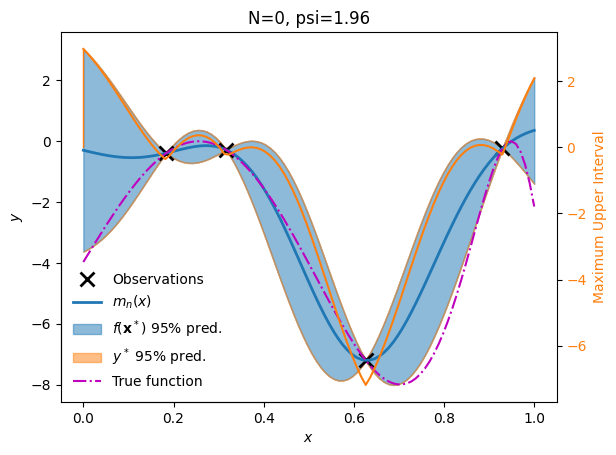

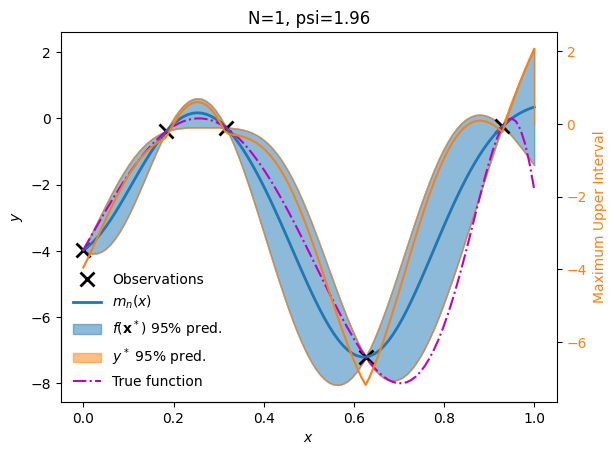

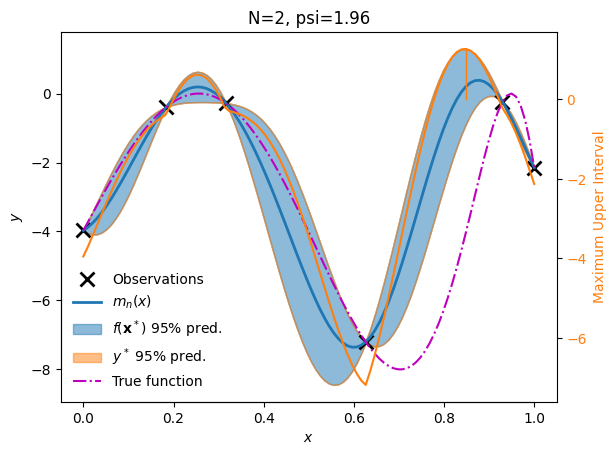

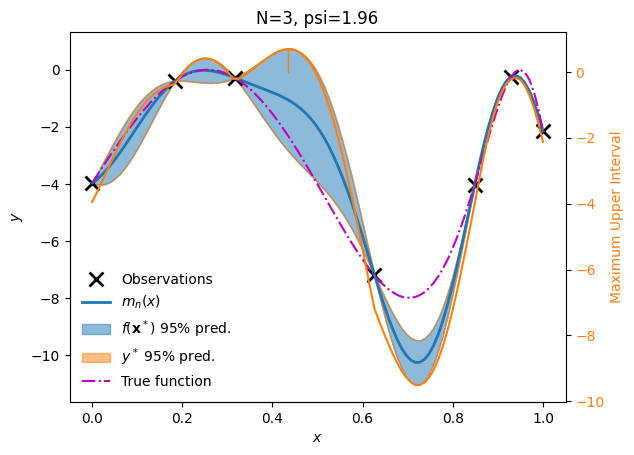

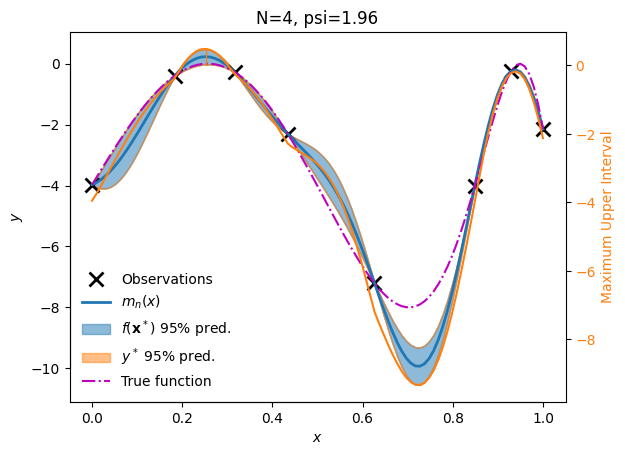

In [1232]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-4
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(f, model, X_design, mui, alpha_params=dict(psi=1.96), max_it=5, plot=1)

#### Probability of Improvement

What if you try to find the point that maximizes the probability of getting an observation greater than the ones you have so far? Let’s derive this. First, let’s call $y_N^*$ the current maximum in your dataset, i.e.,

$$a_n(\mathbf{x})=\mathbb{P}[y>y_n^*+\psi|\mathbf{x},\mathcal{D}_n].$$

There is possible to get an analytical answer because our point predictive distribution is Gaussian. In particular, we get:

\begin{aligned}
a_n(\mathbf{x})& = & \mathbb{P}[y>y_n^*+\psi|x,\mathcal{D}_n] \\
&=& \mathbb{P}\left[\frac{y-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}>\frac{y_n^*+\psi-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}|\mathbf{x},\mathcal{D}_n\right] \\
&=& 1-\mathbb{P}\left[\frac{y-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}\leq\frac{y_n^*+\psi-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}|\mathbf{x},\mathcal{D}_n\right] \\
&=& 1-\Phi\left(\frac{y_n^*+\psi-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}\right) \\
&=& \Phi\left(\frac{\mu_n(\mathbf{x})-y_n^*-\psi}{\sigma_n(\mathbf{x})}\right), 
\end{aligned}

In [1233]:
def poi(m, sigma, ymax, psi=0.0):
    """Return the probability of improvement.

    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration.
    """
    return torch.distributions.Normal(0, 1).cdf((m - ymax - psi) / sigma)

In [1234]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()

plot_iaf(x, model, poi, alpha_params=dict(psi=2.0))

Let’s run the Bayesian global optimization algorithm using the probability of improvement as the information acquisition function. 

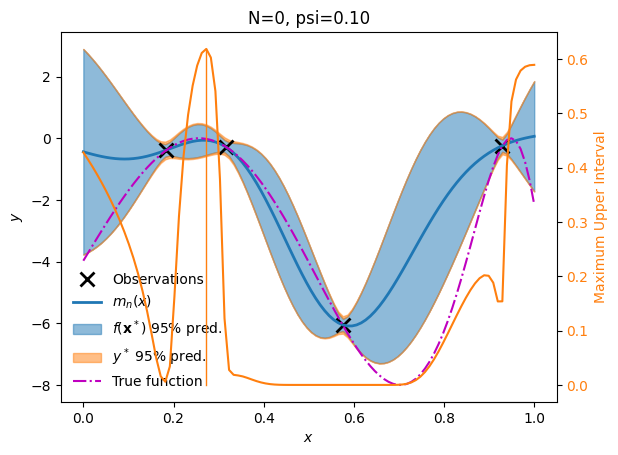

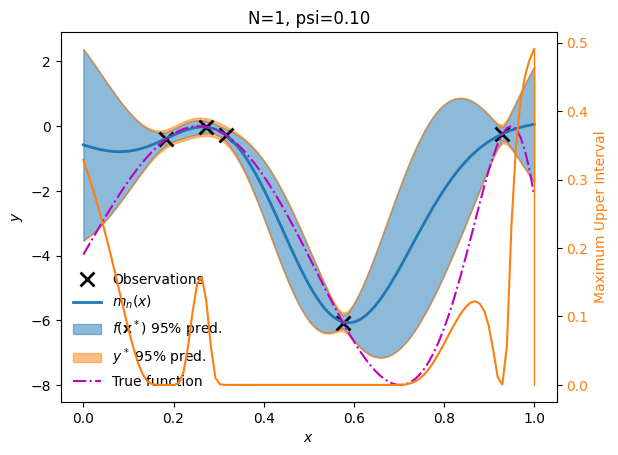

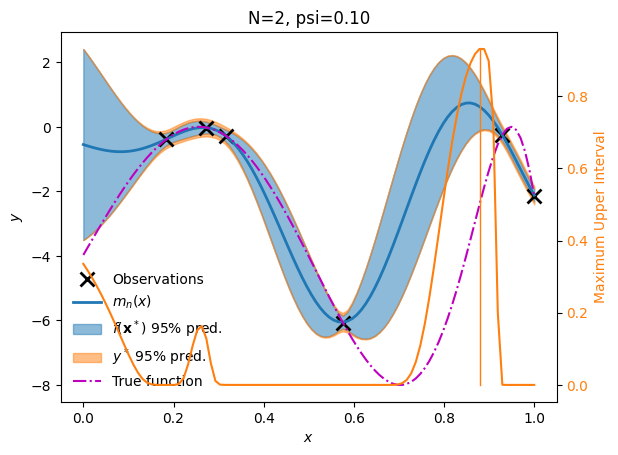

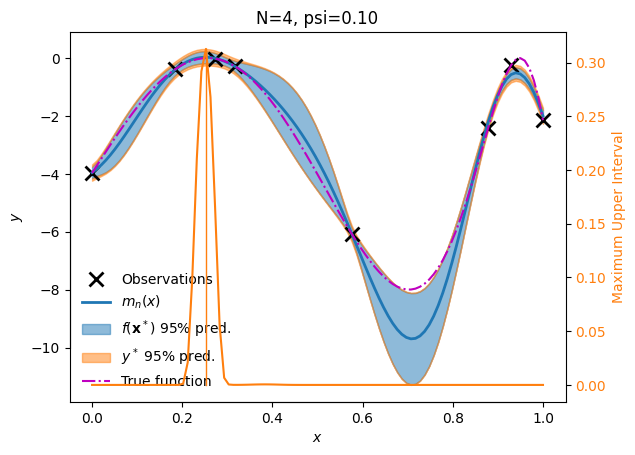

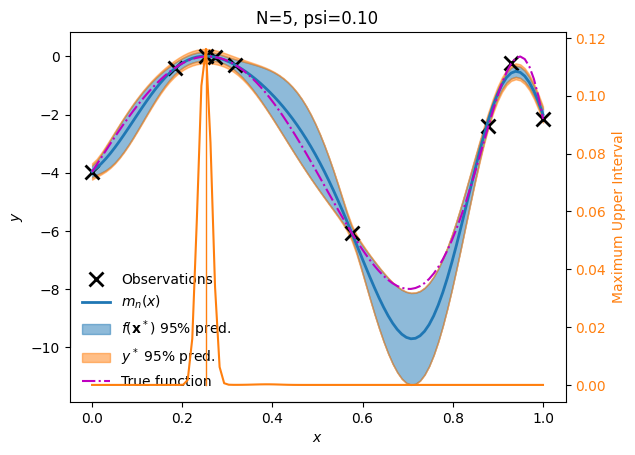

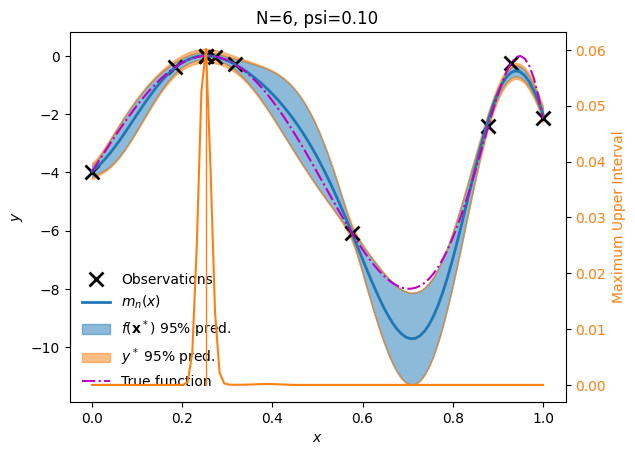

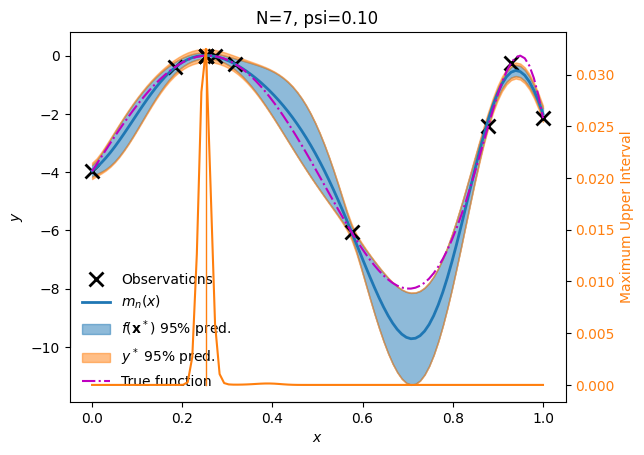

In [1235]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
covar_module = ScaleKernel(RBFKernel())
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-2
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(f, model, X_design, poi, alpha_params=dict(psi=0.1), max_it=10, plot=1)

#### Expected Improvement

The expected improvement is more involved, but it serves as a template for deriving more general information acquisition functions. Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $\mathbf{y}$. How much improvement is that compared to your currently best-observed point $\mathbf{y}_n^*$. It is:

$$I_n(\mathbf{x},y)=\begin{cases}0,&\mathrm{~if~}y\leq y_n^*,\\y-y_n^*,&\text{ otherwise.}&\end{cases}$$

But you don’t know what $y$ is.  Well, the only legitimate thing to do is to take the expectation over what you expected $y$ to be given what you know. So it is:

$$\begin{aligned}\operatorname{EI}_n(\mathbf{x})&=&\int_{-\infty}^\infty I_n(\mathbf{x},y)p(y|\mathbf{x},\mathcal{D}_n)dy\\&=&\int_{-\infty}^{y_n^*}0\cdot p(y|\mathbf{x},\mathcal{D}_n)dy+\int_{y_n^*}^\infty(y-y_n^*)\cdot p(y|\mathbf{x},\mathcal{D}_n)dy.\end{aligned}$$

You can work this out analytically. You will get:

$$\mathrm{EI}_n(\mathbf{x})=(m_n(\mathbf{x})-y_n^*)\Phi\left(\frac{m_n(\mathbf{x})-y_n^*}{\sigma_n(\mathbf{x})}\right)+\sigma_n(x)\phi\left(\frac{m_n(\mathbf{x})-y_n^*}{\sigma_n(\mathbf{x})}\right).$$

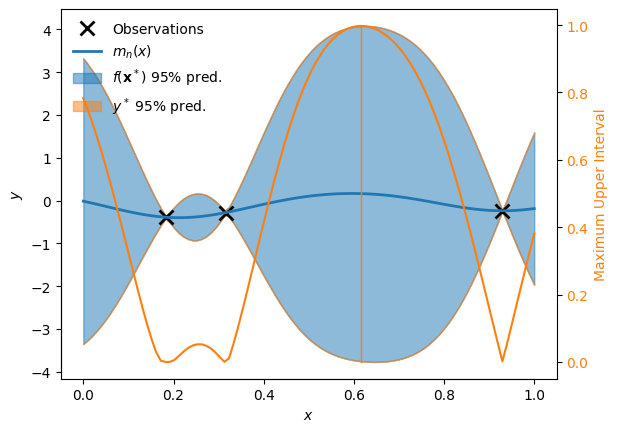

In [1236]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()


def ei(m, sigma, ymax):
    """Return the expected improvement.

    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = diff * torch.distributions.Normal(0, 1).cdf(u) + sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    ei[sigma <= 0.0] = 0.0
    return ei


plot_iaf(x, model, ei)

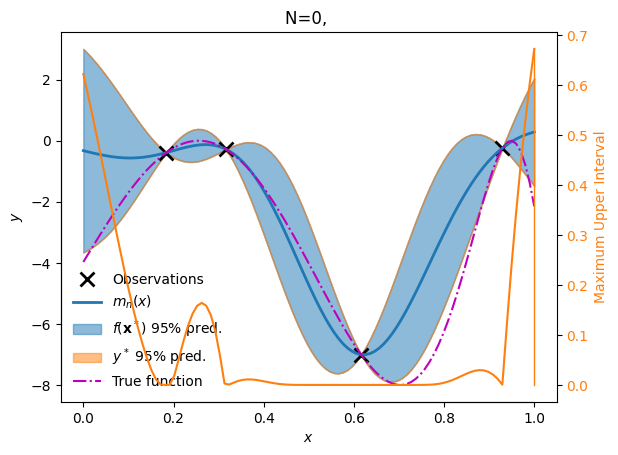

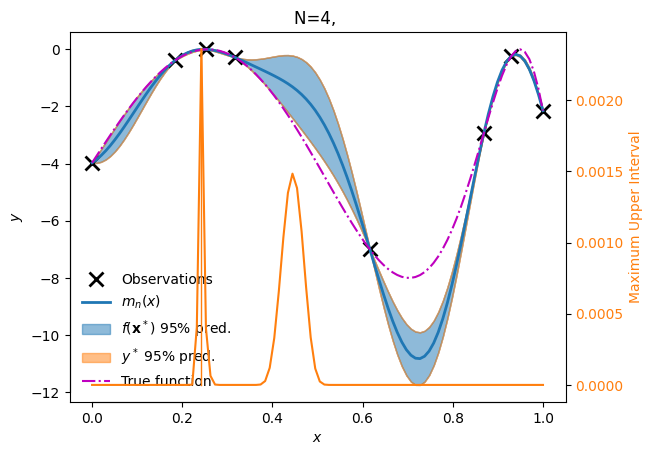

In [1237]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(f, model, X_design, ei, max_it=5, plot=1)

#### Optimizing Noisy Functions

The optimization of noisy functions is relevant when you are dealing with experimentally measured objectives. In such a scenario, you do not observe $f(x)$, but a noisy version. The more straightforward thing to do is to assume that their effect is additive, zero mean, and Gaussian. That is, we assume that:

$$y_i=f(\mathbf{x}_i)+\epsilon_i.$$

The predictive distribution is given by the usual formulas:

$$p(y|\mathbf{x},\mathcal{D}_n)=\mathcal{N}(y|m_n(\mathbf{x}),\sigma_n^2(\mathbf{x})+\sigma^2).$$

In [1238]:
np.random.seed(123456)


def f(x):
    """A function to optimize."""
    return -4 * (1.0 - np.sin(6 * x + 8 * np.exp(6 * x - 7.0)))


# noisy version of the above function
sigma_noise = 0.4
g = lambda x: (f(x) + sigma_noise * np.random.randn(x.shape[0]))

# Generate some data:
n_init = 4
X = np.random.rand(n_init)
Y = g(X)

# Do GPR
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(x, model, f_true=f)

##### Maximum upper interval with noise

The maximum upper interval remains the same:

$$a_n(\mathbf{x})=\mu_n(\mathbf{x})+\psi\sigma_n(\mathbf{x})$$

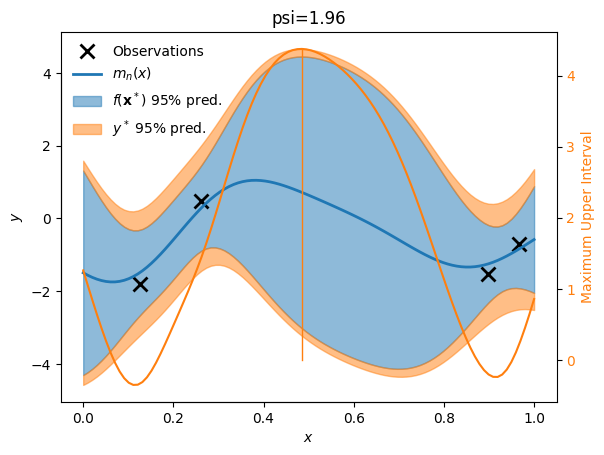

In [1239]:
plot_iaf(x, model, mui, alpha_params=dict(psi=1.96))

##### Probability of improvement with noise

We need to make some modifications to the probability of improvement. First, because they are noisy, we cannot use the $y_n^*$ as the maximum. Instead, Instead, we are looking at the predictive mean of the GP, $m_n(x_i)$, at the corresponding inputs, $x_i$, and we find their maximum. So, define:

$$m_n^*=\max_{1\leq i\leq n}m_n(\mathbf{x}_i).$$

Instead of finding the maximum of the noisy observations, we are smoothing with the predictive mean of the GP and find the maximum of the smoothed versions. The rest is similar. The acquisition function is defined by:

$$a_n(\mathbf{x})=\mathbb{P}[f(\mathbf{x})>m_n^*+\psi|\mathbf{x},\mathcal{D}_n].$$

It is possible to get an analytical answer because our point predictive distribution is Gaussian. In particular, we get:

\begin{aligned}a_n(\mathbf{x})&=&\mathbb{P}[f(\mathbf{x})>m_n^*+\psi|\mathbf{x},\mathcal{D}_n]\\&=&\mathbb{P}\left[\frac{f(\mathbf{x})-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}>\frac{m_n^*+\psi-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}|\mathbf{x},\mathcal{D}_n\right]\\&=&\cdots\\&=&\Phi\left(\frac{\mu_n(\mathbf{x})-m_n^*-\psi}{\sigma_n(\mathbf{x})}\right).\end{aligned}

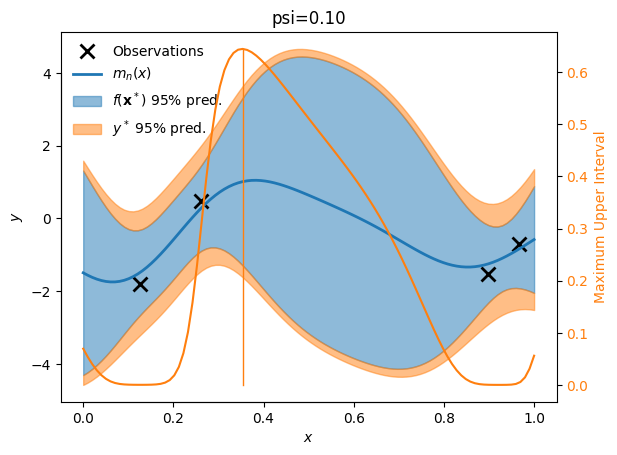

In [1240]:
plot_iaf(x, model, poi, alpha_params=dict(psi=0.1))

##### Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement. How much improvement is that compared to your currently best observed point $m_n^*$

$$I_n(\mathbf{x},f(\mathbf{x}))=\begin{cases}0,&\mathrm{~if~}f(\mathbf{x})\leq m_n^*,\\f(\mathbf{x})-m_n^*,&\text{ otherwise,}\end{cases}$$

Taking the expectation over $y$ would give you:

$$\mathrm{EI}_n(\mathbf{x})=(m_n(\mathbf{x})-m_n^*)\Phi\left(\frac{m_n(\mathbf{x})-m_n^*}{\sigma_n(\mathbf{x})}\right)+\sigma_n(\mathbf{x})\phi\left(\frac{m_n(\mathbf{x})-m_n^*}{\sigma_n(\mathbf{x})}\right).$$

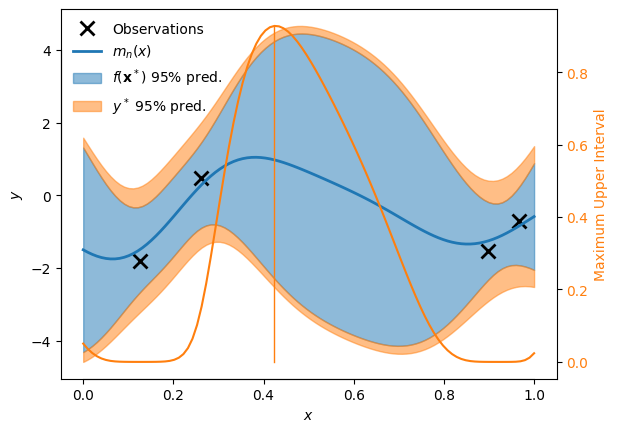

In [1241]:
plot_iaf(x, model, ei)

And here optimization with noise:

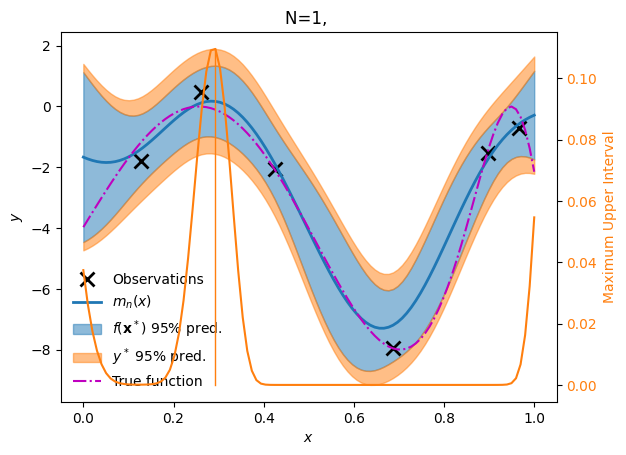

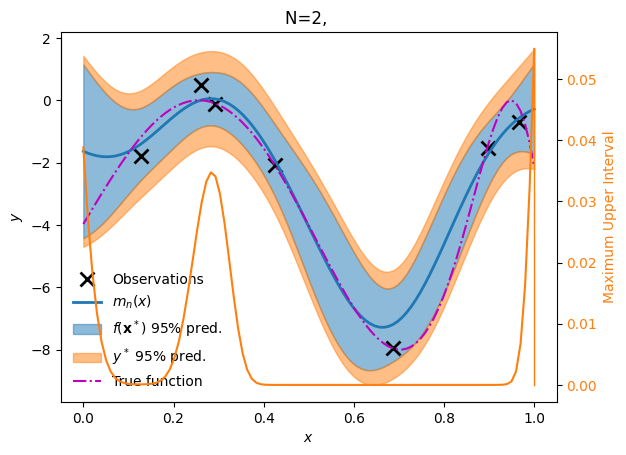

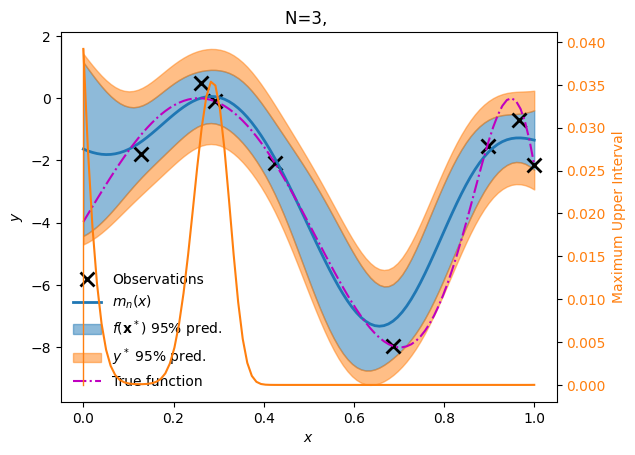

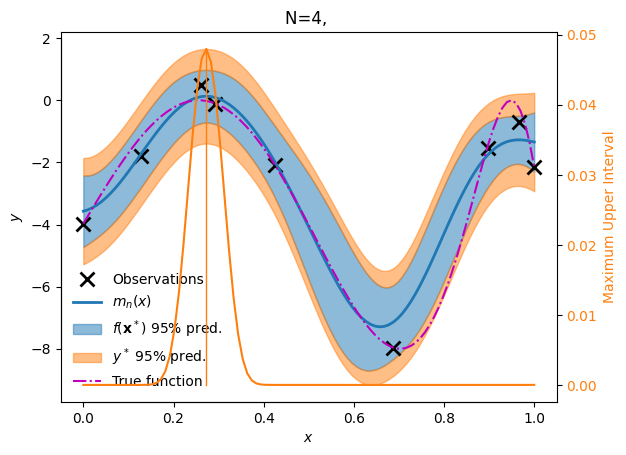

In [1242]:
af_all = maximize(f, model, x, ei, max_it=5, plot=1)

#### Quantifying Epistemic Uncertainty about the Solution of the Optimization problem

Let’s fit the usual GP:

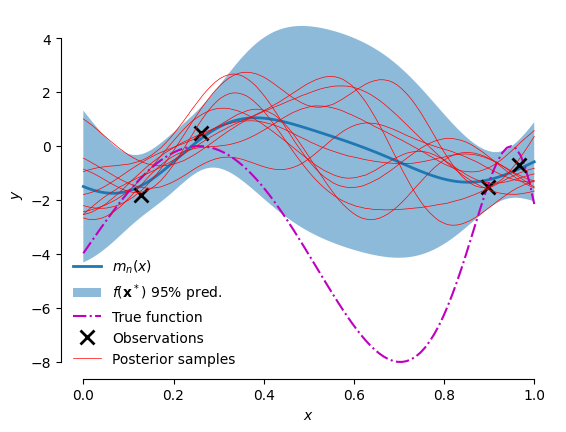

In [1243]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(x, model, f_true=f)

Imagine that you have observed data $D_n$. How certain are you about the location of the maximum? If $n$ is small, you can be more confident. How do you quantify this epistemic uncertainty? Notice that the maximum and the location of the maximum are operators acting on $f$:

$$f^*:=\max[f]:=\max_\mathbf{x}f(\mathbf{x}),$$

and 

$$\mathbf{x}^*:=\mathbf{X}^*[f]:=\arg\max_\mathbf{x}f(\mathbf{x}),$$

respectively. So since we are uncertain about $f$, we will be unsure about $f^*$ and $x^*$.In particular, we want to quantify the joint probability density $p(\mathbf{x}^*,f^*|\mathcal{D}_n)$. Here is what is the formal answer:

$$p(\mathbf{x}^*,f^*|\mathcal{D}_n)=\int\delta(\mathbf{x}^*-\mathbf{X}^*[f])\delta(f^*-\max[f])p(f(\cdot)|\mathcal{D}_n)df(\cdot).$$

The simplest way to do this is through sampling. You just sample functions from $p(f(\cdot)|\mathcal{D}_n)$ , and you find their maximum location of the maximum. Of course, you cannot sample a function. You sample the function values at a finite but dense number of input points and find the maximum amongst these points. Once you get these samples, you look at their histogram.

let’s do it for our working example:

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: xlabel='$f^*$', ylabel='$p(f^*|\\mathcal{D}_n)$'>,
        <Axes: xlabel='$x^*$', ylabel='$p(x^*|\\mathcal{D}_n)$'>],
       dtype=object))

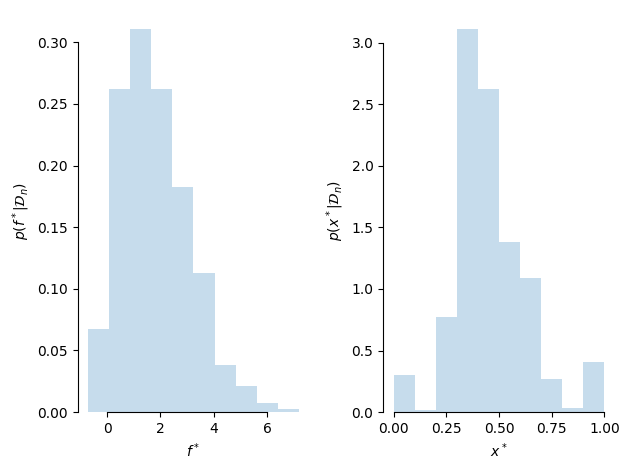

In [1244]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """Plot histograms of the max and argmax of the function represented by the model gpr.

    Arguments
    gpr      -- A trained Gaussian process object.
    X_design -- A set of points to evaluate the response on.

    Keyword Arguments
    n_samples -- The number of samples to take to make the histograms.
    """
    f_star = gpr(X_design)
    f_samples = f_star.sample(sample_shape=torch.Size([n_samples])).numpy()
    max_f_samples = np.max(f_samples, axis=1)
    x_star_samples = X_design.numpy()[np.argmax(f_samples, axis=1)]

    fig, ax = plt.subplots(1, 2)
    ax[0].hist(max_f_samples, density=True, alpha=0.25)
    ax[0].set_xlabel("$f^*$")
    ax[0].set_ylabel("$p(f^*|\mathcal{D}_n)$")

    ax[1].hist(x_star_samples, density=True, alpha=0.25)
    ax[1].set_xlabel("$x^*$")
    ax[1].set_ylabel("$p(x^*|\mathcal{D}_n)$")

    plt.tight_layout()
    sns.despine(trim=True)

    return fig, ax


plot_max_and_argmax(model, x)

Let’s do a few iterations ofour optimization algorithm and repeat that plot.

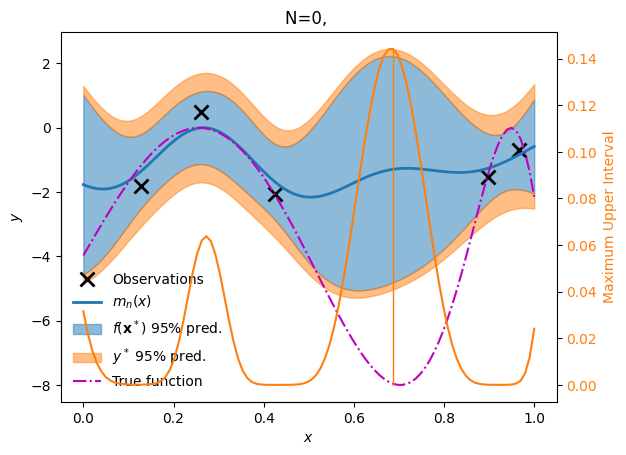

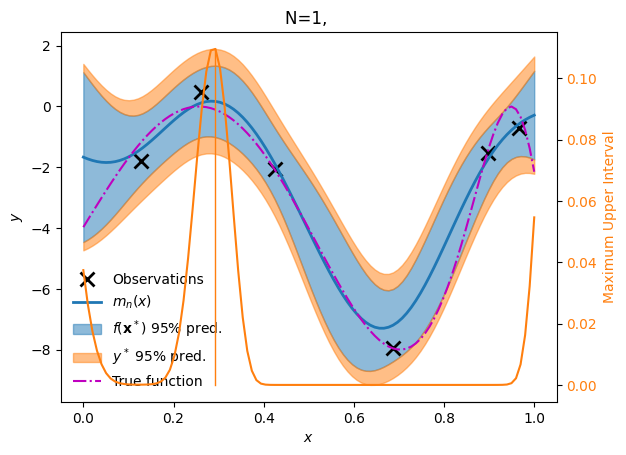

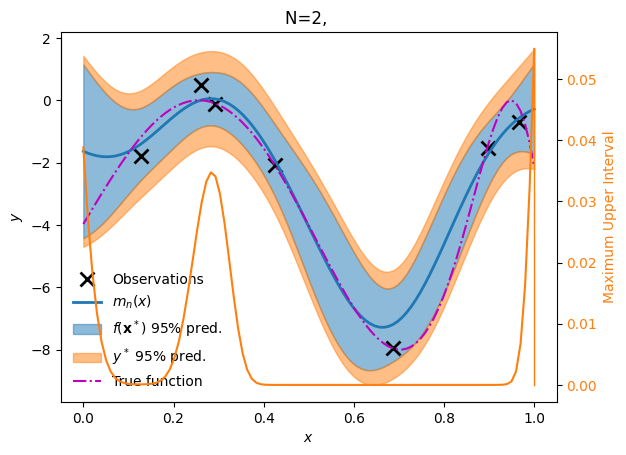

In [1245]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
af_all = maximize(f, model, x, ei, max_it=3, plot=1)

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: xlabel='$f^*$', ylabel='$p(f^*|\\mathcal{D}_n)$'>,
        <Axes: xlabel='$x^*$', ylabel='$p(x^*|\\mathcal{D}_n)$'>],
       dtype=object))

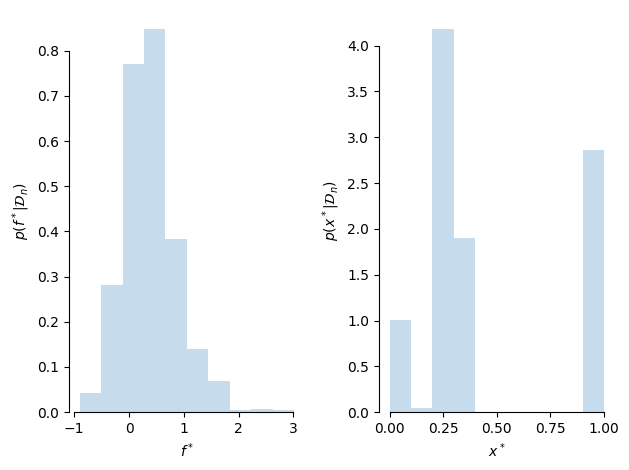

In [1246]:
plot_max_and_argmax(model, x_star)